Commands specific to Google Colab. If running on colab, please use a L4 GPU or T4 GPU with high RAM.

We access the COMRECGC repository through a saved copy on Google Drive. That copy is synchronized with git via the Drive and Git desktop application.

In [3]:
%%capture
!pip install torch_geometric
!pip install torch
!python3 --version

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/COMRECGC-main

/content/drive/MyDrive/COMRECGC-main


In [4]:
import os
import torch
import torch_geometric.utils as torch_utils
import networkx as nx
import random
import matplotlib.pyplot as plt
import pickle
from numba import cuda
from torch.masked import masked_tensor, as_masked_tensor
from tqdm import tqdm
import argparse
import os.path
import torch
import numpy as np
import torch_geometric as tg
from torch_geometric.data import Data, Batch, DataLoader
from torch_geometric.transforms import RemoveIsolatedNodes, ToUndirected
from torch_geometric.utils.convert import to_networkx, from_networkx
import copy
from sklearn import metrics
from sklearn.cluster import DBSCAN, HDBSCAN

In [5]:
import util
import distance
from data import load_dataset # loads datasets
from gnn import load_trained_gnn, load_trained_prediction # loads input graphs, loads trained gnn

# 1: Set up - utils - Just run the following section




In [6]:
def parse_args():
    parser = argparse.ArgumentParser(prog='Global Graph Counterfactuals')

    # Dataset
    parser.add_argument('--dataset', help="Dataset flag", type=str, choices=['mutagenicity', 'aids', 'nci1', 'proteins'])
    parser.add_argument('--theta', type=float, default=0.1, help='distance threshold value during evaluation.')
    parser.add_argument('--device', type=str, help='Cuda device or cpu for gnn', default='0', choices=['0', '1', '2', '3', 'cpu'])

    return parser.parse_args()


def greedy_counterfactual_summary_from_covering_sets(counterfactual_covering, graphs_covered_by, k):
    """
    :param counterfactual_covering: Counterfactual -> Original graphs covered.
    :param graphs_covered_by: Original graphs -> counterfactuals that cover it.
    :param k: Number of counterfactuals in the summary.

    :return: List of indices of selected counterfactuals as summary, and the set of indices of the covered graphs.
    """

    # Greedily add the counterfactuals with maximum coverage in the remaining graphs.
    coverings = {}
    covered = set()

    # while len(indices) < k:
    for i in tqdm(range(1, k + 1)):
        counterfactual_index, covered_indices = max(counterfactual_covering.items(), key=lambda pair: len(pair[1]))
        covered.update(covered_indices)
        counterfactual_covering.pop(counterfactual_index)
        for covered_index in covered_indices:  # Update the mapping.
            for other_counterfactual_index in graphs_covered_by[covered_index] - {counterfactual_index}:
                if other_counterfactual_index in counterfactual_covering:
                    counterfactual_covering[other_counterfactual_index].remove(covered_index)

        coverings[i] = (counterfactual_index, len(covered))

    return coverings


def minimum_distance_cost_summary(distance_matrix, k):
    """
    cost reaching counterfactuals from original graphs with different number of counterfactuals.

    :param distance_matrix: n x c distance matrix where n is the number of original graphs, c is the number of counterfactual candidates
    :param k: Number of counterfactuals in the summary.
    :return selected counterfactuals and cost to reach them for different number of counterfactuals
    """
    costs = {}

    # distance_matrix = distance_matrix.detach().cpu().numpy()
    # min_state = np.array([distance_matrix.max() for _ in range(distance_matrix.shape[0])])
    min_state = torch.repeat_interleave(distance_matrix.max(), distance_matrix.shape[0])
    cost = min_state.sum()
    for i in tqdm(range(1, k + 1)):
        temp = min_state - distance_matrix[:, i - 1]
        gain = (temp * (temp > 0)).sum()
        # min_state = np.vstack([min_state, distance_matrix[:, i - 1]]).min(axis=0)
        min_state = torch.stack([min_state, distance_matrix[:, i - 1]]).min(dim=0).values
        cost = cost - gain
        costs[i] = (cost.item(), None, i - 1, min_state.clone())

    return costs

def greedy_distance_cost_summary(coverage, distance, cost):
    r = 0
    cos = 0
    while r < cost and min(distance) + r < cos:
      greedy = [distance[i]/len(coverage[i]) for i in coverage]
      k = np.argmin(greedy)


    return cov, cos

def prepare_devices(device1, device2):
    device1 = 'cuda:' + device1 if torch.cuda.is_available() and device1 in ['0', '1', '2', '3'] else 'cpu'
    device2 = 'cuda:' + device2 if torch.cuda.is_available() and device2 in ['0', '1', '2', '3'] else 'cpu'

    return device1, device2

In [7]:
def get_args():
    parser = argparse.ArgumentParser(description='Graph Global Counterfactual Summary')
    parser.add_argument('--dataset', type=str, default='mutagenicity', choices=['mutagenicity', 'aids', 'nci1', 'proteins'])
    parser.add_argument('--alpha', type=float, default=0.5, help='alpha value to balance individual and cumulative coverage')
    parser.add_argument('--theta', type=float, default=0.05, help='distance threshold value during training.')
    parser.add_argument('--teleport', type=float, default=0.1, help='teleport probability to input graphs')
    parser.add_argument('--max_steps', type=int, default=50000, help='random walk step size')
    parser.add_argument('--k', type=int, default=100000, help='number of graphs will be selected from counterfactuals')
    parser.add_argument('--device1', type=str, help='Cuda device or cpu for gnn model', default='0')
    parser.add_argument('--device2', type=str, help='Cuda device or cpu for neurosed model', default='0')
    parser.add_argument('--sample_size', type=int, help='Sample count for neighbour graphs', default=10000)
    parser.add_argument('--sample', action='store_true')
    return parser.parse_args()


def calculate_hash(graph_embedding):
    if isinstance(graph_embedding, (np.ndarray,)):
        return hash(graph_embedding.tobytes())
    else:
        raise Exception('graph_embedding should be ndarray')


def node_label_change(graph):
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(graph.x.shape[0]):
        for j in range(graph.x.shape[1]):
            # if graph['node_labels'][i] != j:
            if graph.x[i, j] != 1:
                neighbor_graph_action = ('NLC', i, j)
                neighbor_graphs_actions.append(neighbor_graph_action)
                neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def node_addition(graph):
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(graph.x.shape[0]):
        for j in range(graph.x.shape[1]):  # Add a new node with label j connected with node i.
            neighbor_graph_action = ('NA', i, j)
            neighbor_graphs_actions.append(neighbor_graph_action)
            neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def isolated_node_addition(graph):
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for j in range(graph.x.shape[1]):  # Add a new isolated node with label j
        neighbor_graph_action = ('INA', j, j)
        neighbor_graphs_actions.append(neighbor_graph_action)
        neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def node_removal(graph):
    degree = torch_utils.degree(graph.edge_index[0], num_nodes=graph.num_nodes)
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(len(degree)):
        if degree[i] == 1:  # Remove nodes with exactly one edge only.
            neighbor_graph_action = ('NR', i, i)
            neighbor_graphs_actions.append(neighbor_graph_action)
            neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def isolated_node_removal(graph):
    degree = torch_utils.degree(graph.edge_index[0], num_nodes=graph.num_nodes)
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(len(degree)):
        if degree[i] == 0:  # Remove isolated nodes only.
            neighbor_graph_action = ('INR', i, i)
            neighbor_graphs_actions.append(neighbor_graph_action)
            neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def edge_change(graph, keep_bridge=True, only_removal=False):
    nxg = torch_utils.to_networkx(graph, to_undirected=True)  # 157 µs ± 71.9 µs per loop
    bridges = set(nx.bridges(nxg)) if keep_bridge else set()  # 556 µs ± 31.2 µs per loop
    num_nodes = graph.x.shape[0]
    neighbor_graphs_actions = []
    neighbor_graphs = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if nxg.has_edge(i, j):
                if keep_bridge and (i, j) not in bridges:  # edge exist and its removal does not disconnect the graph
                    neighbor_graph_action = ('ER', i, j)
                else:  # remove edge regardlessly
                    neighbor_graph_action = ('ERR', i, j)
                neighbor_graphs_actions.append(neighbor_graph_action)
                neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
            elif not nxg.has_edge(i, j) and not only_removal:  # add edges
                neighbor_graph_action = ('EA', i, j)
                neighbor_graphs_actions.append(neighbor_graph_action)
                neighbor_graphs.append(neighbor_graph_access(graph, neighbor_graph_action))
    return neighbor_graphs_actions, neighbor_graphs


def neighbor_graph_access(graph, neighbor_graph_action):
    neighbor_graph = graph.clone()
    action = neighbor_graph_action[0]
    if action == 'NOTHING':
        neighbor_graph = neighbor_graph
    elif action == 'NLC':  # node label change
        _, i, j = neighbor_graph_action
        neighbor_graph.x[i] = 0  # 6.93 µs ± 301 ns per loop
        neighbor_graph.x[i][j] = 1  # 7.9 µs ± 420 ns per loop
    elif action == 'NA':  # node addition
        _, i, j = neighbor_graph_action
        neighbor_graph.num_nodes += 1
        neighbor_graph.edge_index = torch.hstack([graph.edge_index, torch.tensor([[i, graph.num_nodes], [graph.num_nodes, i]])])  # 14.1 µs ± 57.3 ns per loop, 3 times faster than padder.
        neighbor_graph.x = torch.vstack([graph.x, torch.nn.functional.one_hot(torch.tensor(j), graph.x.shape[1])])  # 36.8 µs ± 340 ns per loop, similar to padder.
    elif action == 'INA':  # isolated node addition.
        _, i, j = neighbor_graph_action
        neighbor_graph.num_nodes += 1
        neighbor_graph.x = torch.vstack([graph.x, torch.nn.functional.one_hot(torch.tensor(j), graph.x.shape[1])])  # 36.8 µs ± 340 ns per loop, similar to padder.
    elif action in ('NR', 'INR'):  # (isolated) node removal
        _, i, j = neighbor_graph_action
        indices = torch.LongTensor(list(range(i)) + list(range(i + 1, graph.num_nodes)))  # 4.93 µs ± 244 ns per loop
        neighbor_graph.num_nodes -= 1
        neighbor_graph.edge_index = torch_utils.subgraph(indices, graph.edge_index, relabel_nodes=True, num_nodes=graph.num_nodes)[0]  # 80.5 µs ± 992 ns per loop
        neighbor_graph.x = neighbor_graph.x[indices]  # 7.44 µs ± 149 ns per loop
    elif action in ('ER', 'ERR'):  # edge removal (regardlessly)
        _, i, j = neighbor_graph_action
        neighbor_graph.edge_index = graph.edge_index[:, ~((graph.edge_index[0] == i) & (graph.edge_index[1] == j) | (graph.edge_index[0] == j) & (graph.edge_index[1] == i))]  # 78.9 µs ± 1.87 µs per loop
    elif action == 'EA':  # edge addition
        _, i, j = neighbor_graph_action
        neighbor_graph.edge_index = torch.hstack([graph.edge_index, torch.tensor([[i, j], [j, i]])])  # 14 µs ± 262 ns per loop
    else:
        raise NotImplementedError(f'Neighbor edit action {action} not supported. ')
    return neighbor_graph


def is_counterfactual_array_full():
    return len(counterfactual_candidates) >= MAX_COUNTERFACTUAL_SIZE


def get_minimum_frequency():
    return counterfactual_candidates[-1]['frequency']


def is_graph_counterfactual(graph_hash):
    return counterfactual_candidates[graph_index_map[graph_hash]]['importance_parts'][0] >= 0.5


def reorder_counterfactual_candidates(start_idx):
    swap_idx = start_idx - 1
    while swap_idx >= 0 and counterfactual_candidates[start_idx]['frequency'] > counterfactual_candidates[swap_idx]['frequency']:
        swap_idx -= 1
    swap_idx += 1
    if swap_idx < start_idx:
        graph_index_map[counterfactual_candidates[start_idx]['graph_hash']] = swap_idx
        graph_index_map[counterfactual_candidates[swap_idx]['graph_hash']] = start_idx
        counterfactual_candidates[start_idx], counterfactual_candidates[swap_idx] = counterfactual_candidates[swap_idx], counterfactual_candidates[start_idx]
    return swap_idx


def update_input_graphs_covered(add_graph_covering_list=None, remove_graph_covering_list=None):
    global input_graphs_covered
    if add_graph_covering_list is not None:
        input_graphs_covered += add_graph_covering_list
    if remove_graph_covering_list is not None:
        input_graphs_covered -= remove_graph_covering_list


def check_reinforcement_condition(graph_hash):
    return is_graph_counterfactual(graph_hash)


def populate_counterfactual_candidates(graph_hash, importance_parts, input_graphs_covering_list = None, bypass_size = False):
    is_new_graph = False
    if graph_hash in graph_index_map:
        graph_idx = graph_index_map[graph_hash]
        condition = check_reinforcement_condition(graph_hash)
        if condition:
            counterfactual_candidates[graph_idx]['frequency'] += 1
            swap_idx = reorder_counterfactual_candidates(graph_idx)
        else:
            swap_idx = graph_idx
    else:
        is_new_graph = True
        if is_counterfactual_array_full() and not bypass_size:
            deleting_graph_hash = counterfactual_candidates[-1]['graph_hash']
            del graph_index_map[deleting_graph_hash]
            del graph_map[deleting_graph_hash]
            if deleting_graph_hash in transitions:
                del transitions[deleting_graph_hash]
            counterfactual_candidates[-1] = {
                "frequency": get_minimum_frequency() + 1,
                "graph_hash": graph_hash,
                "importance_parts": importance_parts,
                "input_graphs_covering_list": input_graphs_covering_list
            }
        else:
            counterfactual_candidates.append({
                'frequency': 2,
                'graph_hash': graph_hash,
                "importance_parts": importance_parts,
                "input_graphs_covering_list": input_graphs_covering_list
            })
        graph_idx = len(counterfactual_candidates) - 1
        graph_index_map[graph_hash] = graph_idx
        swap_idx = reorder_counterfactual_candidates(graph_idx)

    # updating input_graphs_covered entries
    if swap_idx == graph_idx:  # no swap
        if is_new_graph and graph_idx < len(input_graphs_covered) and is_graph_counterfactual(graph_hash):
            update_input_graphs_covered(add_graph_covering_list=input_graphs_covering_list)
            covering_graphs.add(graph_hash)
    else:  # swapped graph_idx position has swapped graph now
        swapped_graph = counterfactual_candidates[graph_idx]
        if is_graph_counterfactual(swapped_graph['graph_hash']) and graph_idx >= len(input_graphs_covered) > swap_idx:
            update_input_graphs_covered(remove_graph_covering_list=swapped_graph['input_graphs_covering_list'])
            covering_graphs.remove(swapped_graph['graph_hash'])
        if is_new_graph:
            if is_graph_counterfactual(graph_hash) and swap_idx < len(input_graphs_covered):
                update_input_graphs_covered(add_graph_covering_list=input_graphs_covering_list)
                covering_graphs.add(graph_hash)
        else:
            if is_graph_counterfactual(graph_hash) and swap_idx < len(input_graphs_covered) <= graph_idx:
                update_input_graphs_covered(add_graph_covering_list=input_graphs_covering_list)
                covering_graphs.add(graph_hash)


def calculate_importance(hashes, importances, coverage_matrices, importance_args): # not used!
    cum_coverage = None
    ind_coverage = None
    if importance_args['alpha'] < 1:
        # cumulative coverage
        belong = torch.Tensor([hash_ in covering_graphs for hash_ in hashes])
        support = coverage_matrices.to_dense() + (coverage_matrices.to_dense().T * belong).T - input_graphs_covered
        cum_selected = torch.maximum(torch.zeros(input_graphs_covered.shape), support)
        cum_coverage = cum_selected.sum(dim=1) / input_graphs_covered.shape[0]
        cum_coverage = cum_coverage.numpy()
        importances[:, 1] = cum_coverage
    if importance_args['alpha'] > 0:
        # individual coverage
        ind_coverage = coverage_matrices.to_dense().sum(dim=1) / input_graphs_covered.shape[0]
        ind_coverage = ind_coverage.numpy()
        importances[:, 1] = ind_coverage

    importances[:, 1] = alpha * ind_coverage + (1 - alpha) * cum_coverage
    if importances[:, 1].sum() == 0:  # all coverage values are zero, we will only use prediction as importance
        importance_values = importances[:, 0]
    else:
        importance_values = np.prod(importances, axis=1)
    return importance_values


def move_from_known_graph(hashes, importances, importance_args): # REMOVED coverage matrices ARGUMENT
    probabilities = []
    importance_values = [importances[j][0] for j in range(len(hashes))]

    for i, hash_i in enumerate(hashes):
        importance_value = importance_values[i]
        #importance_values = calculate_importance(hashes, np.array(importances), coverage_matrices, importance_args)

        if hash_i in graph_index_map:  # and is_graph_counterfactual(hash_i):  # reinforcing only seen counterfactuals
            frequency = counterfactual_candidates[graph_index_map[hash_i]]['frequency']
        else:
            frequency = get_minimum_frequency() if is_counterfactual_array_full() else 1
        probabilities.append(importance_value * frequency)

    if sum(probabilities) == 0:  # if probability values are all 0, we assign equal probs to all transitions
        probabilities = np.ones(len(probabilities)) / len(probabilities)
    else:
        probabilities = np.array(probabilities) / sum(probabilities)
    selected_hash_idx = random.choices(range(len(hashes)), weights=probabilities)[0]
    return selected_hash_idx


def move_to_next_graph(graphs_hash, start_graphs_hash, importance_args, teleport_probability): #### HERE!, idx is new, can be used in what is neurosed
    not_teleport = False
    if random.uniform(0, 1) < teleport_probability:  # teleport to start
        return None, not not_teleport, None, None, None
    else:
        start_map_data = [graph_map[hash] for hash in start_graphs_hash]
        for graph_hash in graphs_hash: #REVIEW, structure should be ok
          graph, _, _ = graph_map[graph_hash]
          if graph_hash not in transitions:
            neighbor_graphs_actions_edge_change, neighbor_graphs_edge_change = edge_change(graph, keep_bridge=True, only_removal=False)  # still n nodes
            neighbor_graphs_actions_node_label_change, neighbor_graphs_node_label_change = node_label_change(graph)  # still n nodes
            neighbor_graphs_actions_node_addition, neighbor_graphs_node_addition = node_addition(graph)  # n+1 nodes
            neighbor_graphs_actions_node_removal, neighbor_graphs_node_removal = node_removal(graph)  # n-1 nodes

            neighbor_graphs_actions = neighbor_graphs_actions_edge_change + neighbor_graphs_actions_node_label_change + neighbor_graphs_actions_node_addition + neighbor_graphs_actions_node_removal
            all_graph_set = neighbor_graphs_edge_change + neighbor_graphs_node_label_change + neighbor_graphs_node_addition + neighbor_graphs_node_removal

            if sample_size < len(neighbor_graphs_actions) and is_sample:
                samples = random.sample(range(len(neighbor_graphs_actions)), sample_size)
                neighbor_graphs_actions = [neighbor_graphs_actions[sample] for sample in samples]
                all_graph_set = [all_graph_set[sample] for sample in samples]

            # neighbor_graphs_importance_parts, neighbor_graphs_embeddings, neighbor_graphs_coverage_matrix = call(all_graph_set, importance_args)
            neighbor_graphs_importance_parts, neighbor_graphs_embeddings = call(all_graph_set, importance_args)

            target_graphs_set = set()
            target_graphs_hashes = []
            target_graphs_actions = []
            target_graphs_importance_parts = []
            needed_i = []
            target_graphs_embedding = []

            target_graphs = []

            for i in range(len(neighbor_graphs_embeddings)):
                graph_neighbour_hash = calculate_hash(neighbor_graphs_embeddings[i])
                graph_neighbour_embedding = neighbor_graphs_embeddings[i]
                if graph_neighbour_hash not in target_graphs_set:
                    needed_i.append(i)
                    target_graphs_embedding.append(neighbor_graphs_embeddings[i])
                    target_graphs_importance_parts.append(neighbor_graphs_importance_parts[i])
                    target_graphs_hashes.append(graph_neighbour_hash)
                    target_graphs_set.add(graph_neighbour_hash)
                    target_graphs_actions.append(neighbor_graphs_actions[i])

                    target_graphs.append(all_graph_set[i])
            #target_graphs_coverage_matrix = torch.cat([counterfactual_candidates[graph_index_map[graph_hash]]['input_graphs_covering_list'].unsqueeze(0), neighbor_graphs_coverage_matrix[needed_i].to_sparse()])

            #selected_hash_idx = move_from_known_graph(target_graphs_hashes, target_graphs_importance_parts, target_graphs_coverage_matrix, importance_args)
            # update transition part of cur_graph
            # transitions[graph_hash] = (target_graphs_hashes, target_graphs_actions, target_graphs_importance_parts, target_graphs_coverage_matrix)
            #transitions[graph_hash] = (target_graphs_hashes, target_graphs_actions, target_graphs_importance_parts, target_graphs_embedding)

            assert len(graph_map) == len(graph_index_map)
            transitions[graph_hash] = (target_graphs_hashes, target_graphs, target_graphs_importance_parts, target_graphs_embedding)

        select = random.choices(range(len(graphs_hash)))[0]
        graph_hash = graphs_hash[select]

        # target_graphs_hashes, target_graphs_actions, target_graphs_importance_parts, target_graphs_coverage_matrix = transitions[graph_hash]
        target_graphs_hashes, target_graphs, target_graphs_importance_parts, target_graphs_embedding = transitions[graph_hash]

        selected_hash_idx = move_from_known_graph(target_graphs_hashes, target_graphs_importance_parts, importance_args)## OK, IMPORTANT HERE

        selected_hash = target_graphs_hashes[selected_hash_idx]
        selected_importance_parts = target_graphs_importance_parts[selected_hash_idx]

        #selected_action = target_graphs_actions[selected_hash_idx]
        #selected_graph = neighbor_graph_access(graph, selected_action)
        selected_graph = target_graphs[selected_hash_idx]

        selected_embedding = target_graphs_embedding[selected_hash_idx]
        selected_elements = util.graph_element_counts([selected_graph])

        if selected_hash not in graph_map:
            #selected_input_graphs_covering_list = target_graphs_coverage_matrix[selected_hash_idx]
            graph_map[selected_hash] = [selected_graph, selected_embedding, selected_elements]  # next graph addition to memory
        #else:
            #selected_input_graphs_covering_list = counterfactual_candidates[graph_index_map[selected_hash]]['input_graphs_covering_list']
        _, start_embedding, start_elements = graph_map[start_graphs_hash[select]]
        populate_counterfactual_candidates(selected_hash, selected_importance_parts)
        recourse = np.array((selected_embedding - start_embedding) / (selected_elements + start_elements))

        next_hash = []
        next_importance = []
        diff = []
        graph_map_data = []
        s_graph = graph_map[selected_hash]

        for k,i in enumerate(graphs_hash):
          if k != select:
            _, start_embedding, start_elements = start_map_data[k]
            # target_graphs_hashes, _, target_graphs_importance_parts, target_graphs_embedding = transitions[i]

            target_graphs_hashes, target_graphs, target_graphs_importance_parts, target_graphs_embedding = transitions[i]

            selected_elements = util.graph_element_counts(target_graphs)

            matching_recourses = (np.array(target_graphs_embedding)- np.array(start_embedding)) / np.array(selected_elements + start_elements)[:,np.newaxis]

            difference = np.linalg.norm(matching_recourses-recourse, axis=-1)
            match_r = np.argmin(difference)
            select_hash = target_graphs_hashes[match_r]
            next_hash.append(select_hash)
            next_importance.append(target_graphs_importance_parts[match_r])
            diff.append(np.min(difference))
            graph_map_data.append([target_graphs[match_r], target_graphs_embedding[match_r], selected_elements[match_r]])

            populate_counterfactual_candidates(target_graphs_hashes[match_r], target_graphs_importance_parts[match_r]) #bypasses any coverage
          else:
            next_hash.append(selected_hash)
            next_importance.append(selected_importance_parts)
            diff.append(0)
            graph_map_data.append(s_graph)

        for i, hash in enumerate(next_hash):  # NEW
          if hash not in graph_map:
            graph_map[hash] = graph_map_data[i]
            populate_counterfactual_candidates(hash, next_importance[i], bypass_size = True)

        for i, hash in enumerate(start_graphs_hash):
          if hash not in graph_map:
            graph_map[hash] = start_map_data[i]
            populate_counterfactual_candidates(hash, next_importance[i]*0, bypass_size = True)

        return next_hash, not_teleport, recourse, next_importance, diff


def dynamic_teleportation_probabilities():
    input_graphs_covered_exp = np.exp(input_graphs_covered)
    return (1 / input_graphs_covered_exp) / (1 / input_graphs_covered_exp).sum()


In [8]:
def restart_randomwalk(input_graphs, recourse_size): #outputs a list of size recourse_size
    dynamic_probs = dynamic_teleportation_probabilities()
    idx = random.choices(range(dynamic_probs.shape[0]), weights=dynamic_probs, k = recourse_size)
    graphs = input_graphs[idx]
    importance_parts, graph_embeddings = call(graphs, importance_args) #h

    input_graphs_covering_list = idx
    graphs_hash = []
    elements = util.graph_element_counts(graphs)
    for k,i in enumerate(graph_embeddings):
      graph_hash = calculate_hash(i)
      graphs_hash.append(graph_hash)
      if graph_hash not in graph_map:
          graph_map[graph_hash] = [graphs[k], i, elements[k]]
      populate_counterfactual_candidates(graph_hash, np.array([0, 1]))
      input_graphs_covered[input_graphs_covering_list[k]] += 1
    for i in idx:
      if i in start:
        start[i] += 1
      else:
        start[i] = 1
    return graphs_hash, idx


In [9]:
def prepare_and_get(graphs, gnn_model, original_graph_indices, alpha, theta, delta, device1, device2, dataset_name):
    original_graphs = graphs[original_graph_indices.tolist()]
    neurosed_folder = f'data/{dataset_name}/neurosed'
    if not os.path.exists(neurosed_folder):
        os.makedirs(neurosed_folder)

    neurosed_model_path = os.path.join(neurosed_folder, 'best_model.pt')
    neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=neurosed_model_path, device=device2)

    original_graphs_elements_counts = util.graph_element_counts(original_graphs)

    return {
        'gnn_model': gnn_model,
        'alpha': alpha,
        'neurosed_model': neurosed_model,
        'original_graphs': original_graphs,
        'original_graphs_element_counts': original_graphs_elements_counts,
        'distance_threshold': theta,
        'radius': delta,
        'gnn_device': device1,
        'neurosed_device': device2
    }


def call(graphs, wargs): #from restart random walk, need GREED model somewhere in wargs: neurosed model

    try:
        preds, _ = prediction(wargs['gnn_model'], Batch.from_data_list(graphs).to(wargs['gnn_device']))
        graph_embeddings = neurosed_embedding(wargs['neurosed_model'], Batch.from_data_list(graphs).to(wargs['neurosed_device']))
        preds = preds.cpu().numpy()
        graph_embeddings = graph_embeddings.cpu().numpy()
    except RuntimeError as re:
        loader = DataLoader(graphs, batch_size=128)
        preds, graph_embeddings = [], []
        for batch in loader:
            pred, _ = prediction(wargs['gnn_model'], batch.to(wargs['gnn_device']))
            graph_embedding = neurosed_embedding(wargs['neurosed_model'], Batch.from_data_list(graphs).to(wargs['neurosed_device']))
            preds.append(pred)
            graph_embeddings.append(graph_embedding)
        preds = torch.cat(preds).cpu().numpy()
        graph_embeddings = torch.cat(graph_embeddings).cpu().numpy()

    torch.cuda.set_device(wargs['gnn_device'])
    torch.cuda.empty_cache()
    torch.cuda.set_device(wargs['neurosed_device'])
    torch.cuda.empty_cache()

    neurosed_setting(wargs['neurosed_model'], graphs)
    coverage = np.ones(shape=preds.shape)
    torch.cuda.set_device(wargs['neurosed_model'].device)
    torch.cuda.empty_cache()

    return np.stack([preds, coverage]).T, graph_embeddings


@torch.no_grad()
def prediction(model, graphs): # from call
    node_embeddings, graph_embeddings, preds = model(graphs)
    preds = torch.exp(preds)
    return preds[:, [1]].sum(axis=1), graph_embeddings

@torch.no_grad()
def neurosed_embedding(model, graphs):
    graph_embeddings = model.embed_model(graphs)
    return graph_embeddings


@torch.no_grad() ### NEW
def neurosed_setting(model, graphs):
    model.embed_targets(graphs)

@torch.no_grad()
def neurosed_threshold_coverage_estimation(neurosed_model, dataset, original_graphs_element_counts, threshold):
    graphs_element_counts = util.graph_element_counts(dataset)
    batch_size = len(dataset)
    while True:
        try:
            d = neurosed_model.predict_outer_with_queries(dataset, batch_size=batch_size).cpu()
            break
        except RuntimeError as e:
            batch_size = batch_size // 2

    s = torch.cartesian_prod(graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(dataset), len(original_graphs_element_counts))
    d = d / s
    selected = d <= threshold

    return selected.float()

@torch.no_grad()
def neurosed_recourse_coverage_estimation(neurosed_model, graphs, starting_graphs, original_graphs_element_counts, threshold, radius):
    graphs_element_counts = util.graph_element_counts(graphs)
    batch_size = len(graphs)
    while True:
        try:
            d = neurosed_model.predict_recourses(graphs, batch_size=batch_size).cpu()
            break
        except RuntimeError as e:
            batch_size = batch_size // 2

    s = torch.cartesian_prod(graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(graphs), len(original_graphs_element_counts))
    d = d / s
    selected = d <= threshold

    return selected.float()

In [10]:
def predict_recourse(self, queries, batch_size=None): # NEW
    with torch.no_grad():
        self = self.to(self.device)
        if batch_size is None or batch_size == len(queries):
            g = tg.data.Batch.from_data_list(queries).to(self.device)
            gx = self.embed_model(g)
            return self.forward_emb(gx[:, None, :], self.target_emb)
        else:
            loader = tg.data.DataLoader(queries, batch_size=batch_size)
            res_all = []
            for batch in loader:
                gx_ = self.embed_model(batch.to(self.device))
                res = self.forward_emb(gx_[:, None, :], self.target_emb)
                res_all.append(res)
            res_all = torch.cat(res_all, dim=0)
            return res_all

In [11]:
def update_common_recourse_dict(hashes, indx, next_importance, recourse, diff, recourse_num, radius = 0.02):
  select = [i for i in range(len(indx)) if next_importance[i][0] >= 0.5 and diff[i]<= radius]
  cf_idx = [indx[i] for i in select]
  hash_list = [hashes[i] for i in select]
  common_recourse[recourse_num] = set(cf_idx)
  common_recourse_cf_hash[recourse_num] = set(hash_list), recourse

# 2: Run CRE


In [ ]:
def counterfactual_summary_with_randomwalk(input_graphs, importance_args, teleport_probability, max_steps, recourse_size = 2):
    start_graphs_hash, indx = restart_randomwalk(input_graphs, recourse_size) #lists of size recourse_size
    cur_graph_hash = copy.deepcopy(start_graphs_hash)
    recourse_num = 0

    for step in tqdm(range(starting_step, max_steps + 1)):
        traversed_hashes.append(cur_graph_hash)
        next_graph_hash, is_teleported, recourse, next_importance, diff = move_to_next_graph(graphs_hash=cur_graph_hash,
                                                            start_graphs_hash = start_graphs_hash,
                                                            importance_args=importance_args,
                                                            teleport_probability=teleport_probability)

        if is_teleported:
          start_graphs_hash, indx = restart_randomwalk(input_graphs, recourse_size)
          cur_graph_hash = copy.deepcopy(start_graphs_hash)

        assert len(graph_map) == len(graph_index_map) # memory checks
        assert set(graph_index_map.keys()) == set(graph_map.keys())

    save_item = {
        'graph_map': graph_map,
        'graph_index_map': graph_index_map,
        'counterfactual_candidates': counterfactual_candidates,
        'MAX_COUNTERFACTUAL_SIZE': MAX_COUNTERFACTUAL_SIZE,
        'traversed_hashes': traversed_hashes,
        'input_graphs_covered': input_graphs_covered,
        'common_recourse': common_recourse,
    }
    if not os.path.exists(f'results/{dataset_name}/counterfactuals/'):
        os.makedirs(f'results/{dataset_name}/counterfactuals/')
    torch.save(save_item, f'results/{dataset_name}/counterfactuals/comrecgc_k_{recourse_size}.pt')

In [ ]:
for dataset_name in ['mutagenicity','nci1', 'aids','proteins']:
  graph_map = {}  # graph_hash -> {edge_index, x}
  graph_index_map = {}  # graph hash -> index in counterfactual_graphs
  counterfactual_candidates = []  # [{frequency: int, graph_hash: str, importance_parts: tuple, input_graphs_covering_indexes: set}]
  input_graphs_covered = []  # [int] with of number of input graphs
  covering_graphs = set()  # dictionary graph hash which is in first #number input graph counterfactual list (i.e., contributing input_graph_covered)
  transitions = {}  # graph_hash -> {transitions ([hashes], [actions], [importance_parts], tensor(input_graph_covering_for_all_neighbours))}
  common_recourse = {} # index -> counterfactual with
  recourse_num = 0
  common_recourse_cf_hash = {} # index -> counterfactual with
  start = {}

  starting_step = 1
  traversed_hashes = []  # list of traversed graph hashes

  np.random.seed(0)
  random.seed(0)
  torch.manual_seed(0)

  device1, device2 = prepare_devices('0', '0')

  teleport_probability = 0.05
  max_steps = 50000

  dataset_name = 'proteins'

  alpha = 0.5
  sample_size = 1000
  is_sample = 'store_true'

  # global MAX_COUNTERFACTUAL_SIZE
  MAX_COUNTERFACTUAL_SIZE = 100000
  # Load dataset
  graphs = load_dataset(dataset_name)

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device1)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device1)
  preds = preds.cpu().numpy()
  input_graph_indices = np.array(range(len(preds)))[preds == 0]
  input_graphs = graphs[input_graph_indices.tolist()]

  # setting covered graph numbers to 0
  input_graphs_covered = torch.zeros(len(input_graphs), dtype=torch.float)
                                                                                      # alpha,  theta , delta
  importance_args = prepare_and_get(graphs, gnn_model, input_graph_indices, 0.5, 0.1, 0.04, device1=device1, device2=device2, dataset_name=dataset_name)
  counterfactual_summary_with_randomwalk(input_graphs=input_graphs,
                                           importance_args=importance_args,
                                           teleport_probability=teleport_probability,
                                           max_steps=max_steps,
                                           recourse_size = 5)

#3: Clustering algorithm


In [ ]:
def CR_from_can(dataset_name, run_path, method = "cre", threshold_theta = 0.1, cov_k = 100, radius = 0.02, cluster_size = 2, select = 0):
  device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'

  # Load dataset
  graphs = load_dataset(dataset_name)

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device)
  preds = preds.cpu()

  pred_main_idx = torch.where(preds == 0)[0]
  pred_reverse_idx = torch.where(preds != 0)[0]

  original_graphs = graphs[pred_main_idx.tolist()]
  data_counterfactuals = graphs[pred_reverse_idx.tolist()]
  counterfactuals = []

  if method != 'nat':

    counterfactual_rw = torch.load(run_path)
    i = 0
    if method in ['gcfe', 'cre']:
      candidates = counterfactual_rw['counterfactual_candidates']
      # while len(counterfactuals) < len(original_graphs) and len(candidates) > i:
      while len(candidates) > i:

          candidate = candidates[i]
          prediction_importance_value = candidate['importance_parts'][0]
          graph_hash = candidate['graph_hash']
          if prediction_importance_value >= 0.5:
            graph_can = counterfactual_rw['graph_map'][graph_hash]
            if method == "gcfe":
              counterfactuals.append(graph_can)
            else:
              counterfactuals.append(graph_can[0])
          i += 1

    elif method == "select":
      print("select")
      counterfactuals = torch.load(run_path)
      if len(counterfactuals) == 1:
        counterfactuals = counterfactuals[0]
      candidates = []


  print(len(original_graphs), len(counterfactuals), len(candidates))

  neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)
  S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
  original_graphs_element_counts = util.graph_element_counts(original_graphs)
  rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
  s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
  S = S / s
  S = S.T

  idxs = torch.where(S <= threshold_theta)
  idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

  if select:
    counterfactual_covering = {i: set() for i in range(S.shape[1])}  # Counterfactual -> Original graphs covered.
    graphs_covered_by = {j: set() for j in range(S.shape[0])}  # Original graphs -> counterfactuals that cover it.
    for graph_idx, counterfactual_idx in idxs:
        counterfactual_covering[counterfactual_idx].add(graph_idx)
        graphs_covered_by[graph_idx].add(counterfactual_idx)
    coverings = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=counterfactual_covering,
                                                                  graphs_covered_by=graphs_covered_by,
                                                                  k=select)
    selected = [coverings[i][0] for i in coverings]

    counterfactuals = [counterfactuals[i] for i in selected]

    S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
    original_graphs_element_counts = util.graph_element_counts(original_graphs)
    rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
    s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
    S = S / s
    S = S.T

    idxs = torch.where(S <= threshold_theta)
    idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

    print('selection: ', len(original_graphs), len(counterfactuals), len(candidates))


  print("flatres")


  with torch.no_grad():
    neurosed_model = neurosed_model.to(device)
    g = tg.data.Batch.from_data_list(counterfactuals).to(device)
    gx = neurosed_model.embed_model(g)
    f = tg.data.Batch.from_data_list(original_graphs).to(device)
    fx = neurosed_model.embed_model(f)

  res = gx.unsqueeze(1) - fx
  res = res.cpu()
  cf_graph_elements_counts = rw_graphs_element_counts
  sres = torch.cartesian_prod(cf_graph_elements_counts, original_graphs_element_counts).sum(dim=1).view(len(cf_graph_elements_counts), len(original_graphs_element_counts))
  res = torch.div(res,sres.unsqueeze(2))
  flatres = res.view(len(counterfactuals)*fx.shape[0],fx.shape[1])
  norm = torch.norm(res,dim=-1)
  flatnorm = torch.norm(flatres,dim=-1)
  torch.cuda.empty_cache()

  a = np.array([graph_idx + counterfactual_idx*len(original_graphs) for graph_idx, counterfactual_idx in idxs])
  rec = flatres[a]

  print(rec.shape)

  print("clusterize")

  db_2 = DBSCAN(eps=radius, min_samples= cluster_size).fit(rec)

  print(method, sum(db_2.labels_==-1), db_2.labels_.shape, max(db_2.labels_))

  print("summarize")

  common_recourse_gcfe_2 = {}
  cc_gcfe_2 = {}
  hash_gcfe_2 = {}
  for lab in range(max(db_2.labels_)+1):
    l = set()
    h = set()
    points_of_cluster_1 = rec[db_2.labels_==lab]
    index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
    centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
    norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
    points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
    #points_of_cluster_1 = np.array(points_of_cluster_1 / norm_1)
    for i,k in enumerate(points_of_cluster_1):
      if k< radius:
        if idxs[index[i]][0] not in l:
          l.add(idxs[index[i]][0])
          h.add(idxs[index[i]][1])
    common_recourse_gcfe_2[lab] = l
    r = np.linalg.norm(np.array(centroid_of_cluster_1))
    cc_gcfe_2[lab] = r
    hash_gcfe_2[lab] = h

  cov_gcfe_2 = {}
  common_rec_thresh = {}

  for i in common_recourse_gcfe_2:
    if cc_gcfe_2[i]<threshold_theta:
      common_rec_thresh[i] = common_recourse_gcfe_2[i]
      for j in common_recourse_gcfe_2[i]:
        if j not in cov_gcfe_2:
          cov_gcfe_2[j] = {i}
        else:
          cov_gcfe_2[j].add(i)

  coverings_gcfe_2 = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=common_rec_thresh,
                                                                  graphs_covered_by=cov_gcfe_2,
                                                                  k=min(cov_k,len(common_rec_thresh)))
  covering_gcfe_2= []
  cost_gcfe_2 = []
  size_cf_gcfe_2 = []
  r = 0
  hash_set_gcfe_2 = set()
  for i in coverings_gcfe_2:
    covering_gcfe_2.append(coverings_gcfe_2[i][1])
    rec_number = coverings_gcfe_2[i][0]
    for j in hash_gcfe_2[rec_number]:
      hash_set_gcfe_2.add(j)
    r+= cc_gcfe_2[rec_number]
    cost_gcfe_2.append(r)
    size_cf_gcfe_2.append(len(hash_set_gcfe_2))

  print(covering_gcfe_2[0], covering_gcfe_2[-1], size_cf_gcfe_2[-1], cost_gcfe_2[-1])

  del neurosed_model
  del flatres
  del flatnorm
  del rec
  del res
  torch.cuda.empty_cache()


  return covering_gcfe_2, size_cf_gcfe_2, cost_gcfe_2

#3.5 Dataset counterfactuals baseline


In [ ]:
def CR_nat(dataset_name, method = "nat", threshold_theta = 0.1, cov_k = 100, radius = 0.02, cluster_size = 1, select = 0):
  device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'

  # Load dataset
  graphs = load_dataset(dataset_name)

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device)
  preds = preds.cpu()

  pred_main_idx = torch.where(preds == 0)[0]
  pred_reverse_idx = torch.where(preds != 0)[0]

  original_graphs = graphs[pred_main_idx.tolist()]
  data_counterfactuals = graphs[pred_reverse_idx.tolist()]

  counterfactuals = data_counterfactuals

  neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)

  S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
  original_graphs_element_counts = util.graph_element_counts(original_graphs)
  rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
  s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
  S = S / s
  S = S.T

  idxs = torch.where(S <= threshold_theta)
  idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

  print('selection: ', len(original_graphs), len(counterfactuals))


  print("flatres")


  with torch.no_grad():
    neurosed_model = neurosed_model.to(device)
    g = tg.data.Batch.from_data_list(counterfactuals).to(device)
    gx = neurosed_model.embed_model(g)
    f = tg.data.Batch.from_data_list(original_graphs).to(device)
    fx = neurosed_model.embed_model(f)

  res = gx.unsqueeze(1) - fx
  res = res.cpu()
  cf_graph_elements_counts = rw_graphs_element_counts
  sres = torch.cartesian_prod(cf_graph_elements_counts, original_graphs_element_counts).sum(dim=1).view(len(cf_graph_elements_counts), len(original_graphs_element_counts))
  res = torch.div(res,sres.unsqueeze(2))
  flatres = res.view(len(counterfactuals)*fx.shape[0],fx.shape[1])
  norm = torch.norm(res,dim=-1)
  flatnorm = torch.norm(flatres,dim=-1)
  torch.cuda.empty_cache()

  a = np.array([graph_idx + counterfactual_idx*len(original_graphs) for graph_idx, counterfactual_idx in idxs])
  rec = flatres[a]

  print(rec.shape)

  print("clusterize")

  db_2 = DBSCAN(eps=radius, min_samples= cluster_size).fit(rec)

  print(method, sum(db_2.labels_==-1), db_2.labels_.shape, max(db_2.labels_))

  print("summarize")

  common_recourse_gcfe_2 = {}
  cc_gcfe_2 = {}
  hash_gcfe_2 = {}
  for lab in range(max(db_2.labels_)+1):
    l = set()
    h = set()
    points_of_cluster_1 = rec[db_2.labels_==lab]
    index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
    centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
    norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
    points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
    #points_of_cluster_1 = np.array(points_of_cluster_1 / norm_1)
    for i,k in enumerate(points_of_cluster_1):
      if k< radius:
        if idxs[index[i]][0] not in l:
          l.add(idxs[index[i]][0])
          h.add(idxs[index[i]][1])
    common_recourse_gcfe_2[lab] = l
    r = np.linalg.norm(np.array(centroid_of_cluster_1))
    cc_gcfe_2[lab] = r
    hash_gcfe_2[lab] = h

  cov_gcfe_2 = {}
  common_rec_thresh = {}

  for i in common_recourse_gcfe_2:
    if cc_gcfe_2[i]<threshold_theta:
      common_rec_thresh[i] = common_recourse_gcfe_2[i]
      for j in common_recourse_gcfe_2[i]:
        if j not in cov_gcfe_2:
          cov_gcfe_2[j] = {i}
        else:
          cov_gcfe_2[j].add(i)

  coverings_gcfe_2 = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=common_rec_thresh,
                                                                  graphs_covered_by=cov_gcfe_2,
                                                                  k=min(cov_k,len(common_rec_thresh)))
  covering_gcfe_2= []
  cost_gcfe_2 = []
  size_cf_gcfe_2 = []
  r = 0
  hash_set_gcfe_2 = set()
  for i in coverings_gcfe_2:
    covering_gcfe_2.append(coverings_gcfe_2[i][1])
    rec_number = coverings_gcfe_2[i][0]
    for j in hash_gcfe_2[rec_number]:
      hash_set_gcfe_2.add(j)
    r+= cc_gcfe_2[rec_number]
    cost_gcfe_2.append(r)
    size_cf_gcfe_2.append(len(hash_set_gcfe_2))

  print(covering_gcfe_2[0], covering_gcfe_2[-1], size_cf_gcfe_2[-1], cost_gcfe_2[-1])

  del neurosed_model
  del flatres
  del flatnorm
  del rec
  del res
  torch.cuda.empty_cache()


  return covering_gcfe_2, size_cf_gcfe_2, cost_gcfe_2

In [ ]:
threshold = {"aids":0.1, "proteins":0.15, "nci1":0.1, "mutagenicity":0.1}

for dataset_name in ["nci1","proteins","aids","mutagenicity"]:
  rez = CR_nat(dataset_name, threshold_theta = threshold[dataset_name], cov_k = 100, radius = 0.02)
  with open(f'./results/{dataset_name}/cr_select/results_nat_2.pkl', 'wb') as f:
    pickle.dump(rez, f)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


selection:  1971 2007
flatres
torch.Size([3707, 64])
clusterize
nat 0 (3707,) 3464
summarize


100%|██████████| 100/100 [00:00<00:00, 2433.82it/s]


4 168 80 9.019060969352722


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


selection:  366 747
flatres
torch.Size([1523, 64])
clusterize
nat 0 (1523,) 1500
summarize


100%|██████████| 100/100 [00:00<00:00, 5343.27it/s]


3 106 59 12.952793441712856


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


selection:  1473 364
flatres
torch.Size([16, 64])
clusterize
nat 0 (16,) 10
summarize


100%|██████████| 11/11 [00:00<00:00, 66576.25it/s]

1 6 10 0.9737056642770767



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


selection:  2438 1870
flatres
torch.Size([14124, 64])
clusterize
nat 0 (14124,) 11986
summarize


100%|██████████| 100/100 [00:00<00:00, 602.55it/s]


8 253 80 8.34245104342699


# 5.0 experiment selected

In [ ]:
device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'
thresh = {'mutagenicity': 0.1, 'proteins': 0.15, 'aids': 0.1, 'nci1': 0.1}
np.random.seed(seed=0)

#for dataset_name in ['aids', 'proteins', 'nci1', 'mutagenicity']:
for dataset_name in ['mutagenicity']:

  # Load dataset
  graphs = load_dataset(dataset_name)
  threshold_theta = thresh[dataset_name]

  # Load GNN model for dataset
  gnn_model = load_trained_gnn(dataset_name, device=device)
  gnn_model.eval()

  # Load prediction based on model
  preds = load_trained_prediction(dataset_name, device=device)
  preds = preds.cpu()

  pred_main_idx = torch.where(preds == 0)[0]
  pred_reverse_idx = torch.where(preds != 0)[0]

  original_graphs = graphs[pred_main_idx.tolist()]
  data_counterfactuals = graphs[pred_reverse_idx.tolist()]

  #for method in ['gcfe', 'cre']:
  for method in ['cre']:

    counterfactuals = []
    if method == 'cre':
      run_path = f'./results/{dataset_name}/finalcre_test/counterfactuals_5.pt'
    else:
      run_path = f'./results/{dataset_name}/runs/counterfactuals.pt'

    if method != 'nat':

      counterfactual_rw = torch.load(run_path)
      i = 0
      if method in ['gcfe', 'cre']:
        candidates = counterfactual_rw['counterfactual_candidates']
        # while len(counterfactuals) < len(original_graphs) and len(candidates) > i:
        while len(candidates) > i:

            candidate = candidates[i]
            prediction_importance_value = candidate['importance_parts'][0]
            graph_hash = candidate['graph_hash']
            if prediction_importance_value >= 0.5:
              graph_can = counterfactual_rw['graph_map'][graph_hash]
              if method == "gcfe":
                counterfactuals.append(graph_can)
              else:
                counterfactuals.append(graph_can[0])
            i += 1
    if len(counterfactuals) < pred_main_idx.shape[0]:
      for i in data_counterfactuals:
        i.edge_weight = i.edge_attr
        i.pred = i.y
        del i['edge_attr']
        del i['y']
        counterfactuals.append(i)

      for i in counterfactuals:
        if 'edge_attr' in i.keys():
          i.edge_weight = i.edge_attr
          del i['edge_attr']
        if "y" in i.keys():
          del i['y']
        if "edge_weight" not in i.keys():
          i.edge_weight = torch.ones(i.edge_index.shape[1])


    print(len(original_graphs), len(counterfactuals), len(candidates))

    #for var in ['min','rand']:
    for var in ['min']:

      if var == 'min':

        neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)
        S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
        original_graphs_element_counts = util.graph_element_counts(original_graphs)
        rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
        s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
        S = S / s
        S = S.T

        idxs = torch.where(S <= threshold_theta)
        idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]
        mm = torch.argmin(S, dim=1)
        a = set(mm[i].item() for i in range(mm.shape[0]))
        rez = [counterfactuals[i] for i in a]

        torch.save(rez, f'./results/{dataset_name}/benchmark/results_{method}_{var}.pt')
      elif var == 'rand':
        for j in range(5):
          a = np.random.randint(0, len(counterfactuals), len(original_graphs))
          rez = [[counterfactuals[i] for i in a]]


KeyboardInterrupt: 

In [ ]:
np.random.randint(0, 10, 5)

array([4, 5, 4, 1, 8])

In [ ]:
device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'
thresh = {'mutagenicity': 0.1, 'proteins': 0.15, 'aids': 0.1, 'nci1': 0.1}
dataset_name = 'mutagenicity'

# Load dataset
graphs = load_dataset(dataset_name)
threshold_theta = thresh[dataset_name]

# Load GNN model for dataset
gnn_model = load_trained_gnn(dataset_name, device=device)
gnn_model.eval()

# Load prediction based on model
preds = load_trained_prediction(dataset_name, device=device)
preds = preds.cpu()

pred_main_idx = torch.where(preds == 0)[0]
pred_reverse_idx = torch.where(preds != 0)[0]

original_graphs = graphs[pred_main_idx.tolist()]
data_counterfactuals = graphs[pred_reverse_idx.tolist()]


In [ ]:
original_graphs[0].x.shape

torch.Size([16, 10])

In [ ]:
original_graphs[0]

Data(x=[16, 10], edge_index=[2, 32], y=0, num_nodes=16)

In [ ]:
from torch_geometric.datasets import TUDataset

In [ ]:
graphs = TUDataset(root='/content/drive/MyDrive/GCFExplainer-main/GCFExplainer-main/Mutagenicity', name='Mutagenicity')

# we remove graphs if they include node classes which has frequency less than or equal to 50.
x_all = []
for graph in graphs:
    x_all.append(graph.x.sum(dim=0))
x_all = torch.stack(x_all).sum(dim=0)
atoms_to_keep = torch.where(x_all > 50)[0]
print(f'There are {len(atoms_to_keep)} valid number of labels!')

count = 0
for i, graph in enumerate(graphs):
    # Create data object
    if graph.x.sum() == graph.x[:, atoms_to_keep].sum():
        # Create data
        x = graph.x[:, atoms_to_keep]
        data = Data(edge_index=graph.edge_index.clone(),
                    y=torch.tensor(graph.y.item()),  # 0 is mutagenetic, which is undesired for drug discovery.
                    # node_labels=self.label_from_one_hot(x),
                    x=x.clone(),
                    num_nodes=graph.num_nodes
                    )
        count += 1
print(f"There are {count} graphs!")

There are 10 valid number of labels!
There are 4308 graphs!


# 5.05 Common recourse analysis


In [ ]:
device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'
dataset_name = "mutagenicity"
run_path = '/content/drive/MyDrive/GCFExplainer-main/GCFExplainer-main/results/mutagenicity/benchmark/results_cre_min.pt'
method = "select"
threshold_theta = 0.1
cov_k = 100
radius = 0.02
cluster_size = 3
select = 0
# Load dataset
graphs = load_dataset(dataset_name)

# Load GNN model for dataset
gnn_model = load_trained_gnn(dataset_name, device=device)
gnn_model.eval()

# Load prediction based on model
preds = load_trained_prediction(dataset_name, device=device)
preds = preds.cpu()

pred_main_idx = torch.where(preds == 0)[0]
pred_reverse_idx = torch.where(preds != 0)[0]

original_graphs = graphs[pred_main_idx.tolist()]
data_counterfactuals = graphs[pred_reverse_idx.tolist()]
counterfactuals = []

if method != 'nat':

  counterfactual_rw = torch.load(run_path)
  i = 0
  if method in ['gcfe', 'cre']:
    candidates = counterfactual_rw['counterfactual_candidates']
    # while len(counterfactuals) < len(original_graphs) and len(candidates) > i:
    while len(candidates) > i:

        candidate = candidates[i]
        prediction_importance_value = candidate['importance_parts'][0]
        graph_hash = candidate['graph_hash']
        if prediction_importance_value >= 0.5:
          graph_can = counterfactual_rw['graph_map'][graph_hash]
          if method == "gcfe":
            counterfactuals.append(graph_can)
          else:
            counterfactuals.append(graph_can[0])
        i += 1

  elif method == "select":
    print("select")
    counterfactuals = torch.load(run_path)
    if len(counterfactuals) == 1:
      counterfactuals = counterfactuals[0]
    candidates = []


print(len(original_graphs), len(counterfactuals), len(candidates))

neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)
S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
original_graphs_element_counts = util.graph_element_counts(original_graphs)
rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
S = S / s
S = S.T

idxs = torch.where(S <= threshold_theta)
idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

if select:
  counterfactual_covering = {i: set() for i in range(S.shape[1])}  # Counterfactual -> Original graphs covered.
  graphs_covered_by = {j: set() for j in range(S.shape[0])}  # Original graphs -> counterfactuals that cover it.
  for graph_idx, counterfactual_idx in idxs:
      counterfactual_covering[counterfactual_idx].add(graph_idx)
      graphs_covered_by[graph_idx].add(counterfactual_idx)
  coverings = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=counterfactual_covering,
                                                                graphs_covered_by=graphs_covered_by,
                                                                k=select)
  selected = [coverings[i][0] for i in coverings]

  counterfactuals = [counterfactuals[i] for i in selected]

  S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
  original_graphs_element_counts = util.graph_element_counts(original_graphs)
  rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
  s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
  S = S / s
  S = S.T

  idxs = torch.where(S <= threshold_theta)
  idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

  print('selection: ', len(original_graphs), len(counterfactuals), len(candidates))


print("flatres")


with torch.no_grad():
  neurosed_model = neurosed_model.to(device)
  g = tg.data.Batch.from_data_list(counterfactuals).to(device)
  gx = neurosed_model.embed_model(g)
  f = tg.data.Batch.from_data_list(original_graphs).to(device)
  fx = neurosed_model.embed_model(f)

res = gx.unsqueeze(1) - fx
res = res.cpu()
cf_graph_elements_counts = rw_graphs_element_counts
sres = torch.cartesian_prod(cf_graph_elements_counts, original_graphs_element_counts).sum(dim=1).view(len(cf_graph_elements_counts), len(original_graphs_element_counts))
res = torch.div(res,sres.unsqueeze(2))
flatres = res.view(len(counterfactuals)*fx.shape[0],fx.shape[1])
norm = torch.norm(res,dim=-1)
flatnorm = torch.norm(flatres,dim=-1)
torch.cuda.empty_cache()

a = np.array([graph_idx + counterfactual_idx*len(original_graphs) for graph_idx, counterfactual_idx in idxs])
rec = flatres[a]

print(rec.shape)

print("clusterize")

db_2 = DBSCAN(eps=radius, min_samples= cluster_size).fit(rec)

print(method, sum(db_2.labels_==-1), db_2.labels_.shape, max(db_2.labels_))

print("summarize")

common_recourse_gcfe_2 = {}
cc_gcfe_2 = {}
hash_gcfe_2 = {}
for lab in range(max(db_2.labels_)+1):
  l = set()
  h = set()
  points_of_cluster_1 = rec[db_2.labels_==lab]
  index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
  centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
  norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
  points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
  #points_of_cluster_1 = np.array(points_of_cluster_1 / norm_1)
  for i,k in enumerate(points_of_cluster_1):
    if k< radius:
      if idxs[index[i]][0] not in l:
        l.add(idxs[index[i]][0])
        h.add(idxs[index[i]][1])
  common_recourse_gcfe_2[lab] = l
  r = np.linalg.norm(np.array(centroid_of_cluster_1))
  cc_gcfe_2[lab] = r
  hash_gcfe_2[lab] = h

cov_gcfe_2 = {}
common_rec_thresh = {}

for i in common_recourse_gcfe_2:
  if cc_gcfe_2[i]<threshold_theta:
    common_rec_thresh[i] = common_recourse_gcfe_2[i]
    for j in common_recourse_gcfe_2[i]:
      if j not in cov_gcfe_2:
        cov_gcfe_2[j] = {i}
      else:
        cov_gcfe_2[j].add(i)

coverings_gcfe_2 = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=common_rec_thresh,
                                                                graphs_covered_by=cov_gcfe_2,
                                                                k=min(cov_k,len(common_rec_thresh)))
covering_gcfe_2= []
cost_gcfe_2 = []
size_cf_gcfe_2 = []
r = 0
hash_set_gcfe_2 = set()
for i in coverings_gcfe_2:
  covering_gcfe_2.append(coverings_gcfe_2[i][1])
  rec_number = coverings_gcfe_2[i][0]
  for j in hash_gcfe_2[rec_number]:
    hash_set_gcfe_2.add(j)
  r+= cc_gcfe_2[rec_number]
  cost_gcfe_2.append(r)
  size_cf_gcfe_2.append(len(hash_set_gcfe_2))

print(covering_gcfe_2[0], covering_gcfe_2[-1], size_cf_gcfe_2[-1], cost_gcfe_2[-1])

select
2438 2260 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([89167, 64])
clusterize
select 71816 (89167,) 3221
summarize


100%|██████████| 100/100 [00:00<00:00, 2292.52it/s]

869 1139 912 6.563558012247086


#5.06 from dataset

In [ ]:
device = 'cuda:' + '0' if torch.cuda.is_available() else 'cpu'
dataset_name = "mutagenicity"
method = "select"
threshold_theta = 0.1
cov_k = 100
radius = 0.02
cluster_size = 2
select = 0
# Load dataset
graphs = load_dataset(dataset_name)

# Load GNN model for dataset
gnn_model = load_trained_gnn(dataset_name, device=device)
gnn_model.eval()

# Load prediction based on model
preds = load_trained_prediction(dataset_name, device=device)
preds = preds.cpu()

pred_main_idx = torch.where(preds == 0)[0]
pred_reverse_idx = torch.where(preds != 0)[0]

original_graphs = graphs[pred_main_idx.tolist()]
data_counterfactuals = graphs[pred_reverse_idx.tolist()]
counterfactuals = data_counterfactuals


print(len(original_graphs), len(counterfactuals))

neurosed_model = distance.load_neurosed(original_graphs, neurosed_model_path=f'data/{dataset_name}/neurosed/best_model.pt', device=device)
S = neurosed_model.predict_outer_with_queries(counterfactuals, batch_size=1000).cpu()
original_graphs_element_counts = util.graph_element_counts(original_graphs)
rw_graphs_element_counts = util.graph_element_counts(counterfactuals)
s = torch.cartesian_prod(rw_graphs_element_counts, original_graphs_element_counts).sum(dim=1).view(len(rw_graphs_element_counts), len(original_graphs_element_counts))
S = S / s
S = S.T

idxs = torch.where(S <= threshold_theta)
idxs = [(idxs[0][i].item(), idxs[1][i].item()) for i in range(idxs[0].shape[0])]

print("flatres")


with torch.no_grad():
  neurosed_model = neurosed_model.to(device)
  g = tg.data.Batch.from_data_list(counterfactuals).to(device)
  gx = neurosed_model.embed_model(g)
  f = tg.data.Batch.from_data_list(original_graphs).to(device)
  fx = neurosed_model.embed_model(f)

res = gx.unsqueeze(1) - fx
res = res.cpu()
cf_graph_elements_counts = rw_graphs_element_counts
sres = torch.cartesian_prod(cf_graph_elements_counts, original_graphs_element_counts).sum(dim=1).view(len(cf_graph_elements_counts), len(original_graphs_element_counts))
res = torch.div(res,sres.unsqueeze(2))
flatres = res.view(len(counterfactuals)*fx.shape[0],fx.shape[1])
norm = torch.norm(res,dim=-1)
flatnorm = torch.norm(flatres,dim=-1)
torch.cuda.empty_cache()

a = np.array([graph_idx + counterfactual_idx*len(original_graphs) for graph_idx, counterfactual_idx in idxs])
rec = flatres[a]

print(rec.shape)

print("clusterize")

db_2 = DBSCAN(eps=radius, min_samples= cluster_size).fit(rec)

print(method, sum(db_2.labels_==-1), db_2.labels_.shape, max(db_2.labels_))

print("summarize")

common_recourse_gcfe_2 = {}
cc_gcfe_2 = {}
hash_gcfe_2 = {}
for lab in range(max(db_2.labels_)+1):
  l = set()
  h = set()
  points_of_cluster_1 = rec[db_2.labels_==lab]
  index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
  centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
  norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
  points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
  #points_of_cluster_1 = np.array(points_of_cluster_1 / norm_1)
  for i,k in enumerate(points_of_cluster_1):
    if k< radius:
      if idxs[index[i]][0] not in l:
        l.add(idxs[index[i]][0])
        h.add(idxs[index[i]][1])
  common_recourse_gcfe_2[lab] = l
  r = np.linalg.norm(np.array(centroid_of_cluster_1))
  cc_gcfe_2[lab] = r
  hash_gcfe_2[lab] = h

cov_gcfe_2 = {}
common_rec_thresh = {}

for i in common_recourse_gcfe_2:
  if cc_gcfe_2[i]<threshold_theta:
    common_rec_thresh[i] = common_recourse_gcfe_2[i]
    for j in common_recourse_gcfe_2[i]:
      if j not in cov_gcfe_2:
        cov_gcfe_2[j] = {i}
      else:
        cov_gcfe_2[j].add(i)

coverings_gcfe_2 = greedy_counterfactual_summary_from_covering_sets(counterfactual_covering=common_rec_thresh,
                                                                graphs_covered_by=cov_gcfe_2,
                                                                k=min(cov_k,len(common_rec_thresh)))
covering_gcfe_2= []
cost_gcfe_2 = []
size_cf_gcfe_2 = []
r = 0
hash_set_gcfe_2 = set()
for i in coverings_gcfe_2:
  covering_gcfe_2.append(coverings_gcfe_2[i][1])
  rec_number = coverings_gcfe_2[i][0]
  for j in hash_gcfe_2[rec_number]:
    hash_set_gcfe_2.add(j)
  r+= cc_gcfe_2[rec_number]
  cost_gcfe_2.append(r)
  size_cf_gcfe_2.append(len(hash_set_gcfe_2))

print(covering_gcfe_2[0], covering_gcfe_2[-1], size_cf_gcfe_2[-1], cost_gcfe_2[-1])

2438 1870


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([14124, 64])
clusterize
select 10523 (14124,) 1463
summarize


100%|██████████| 100/100 [00:00<00:00, 5232.94it/s]

8 253 80 8.342450809665024


In [ ]:
rez = [db_2, rec, idxs, coverings_gcfe_2]
torch.save(rez, '/content/drive/MyDrive/GCFExplainer-main/GCFExplainer-main/common_rec_draw.pt')

In [ ]:
db_2, rec, idxs, coverings_gcfe_2 = torch.load('/content/drive/MyDrive/GCFExplainer-main/GCFExplainer-main/common_rec_draw.pt' )

In [ ]:
len(common_recourse_gcfe_2), len(original_graphs), len(counterfactuals), len(coverings_gcfe_2)

(1464, 2438, 1870, 100)

In [ ]:
coverings_gcfe_2[2], common_recourse_gcfe_2[12], hash_gcfe_2[12]

((47, 14), set(), {305})

In [ ]:
lab = 47
points_of_cluster_1 = rec[db_2.labels_==lab]
index = [ j for j,k in enumerate(db_2.labels_==lab) if k]
centroid_of_cluster_1 = torch.mean(points_of_cluster_1, axis=0)
norm_1 = torch.norm(points_of_cluster_1, dim=-1) + torch.norm(centroid_of_cluster_1)
points_of_cluster_1 = torch.norm(points_of_cluster_1 - centroid_of_cluster_1,dim=-1)
for i,k in enumerate(points_of_cluster_1):
  if k< radius:
      print("input graph: ", idxs[index[i]][0], ", counterfactual: ",idxs[index[i]][1])

input graph:  115 , counterfactual:  747
input graph:  410 , counterfactual:  747
input graph:  467 , counterfactual:  747
input graph:  687 , counterfactual:  747
input graph:  1009 , counterfactual:  747
input graph:  1579 , counterfactual:  747


In [ ]:
atoms_to_keep= [ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10]
atoms = {0: 'C', 1: 'O', 2: 'Cl', 3: 'H', 4: 'N', 5: 'F', 6: 'Br', 7: 'S', 8: 'P', 10: 'Na'}
colors_dict = {"C": "grey", "N": "green", "O": "red", "Cl": "blue", "H": "white" , "P": "purple", "S": "yellow", "F": "pink"}

def generate_graph(graph):
    data = Data(edge_index=graph.edge_index.clone(),
                            y=torch.tensor(graph.y.item()),
                            x=torch.argmax(graph.x, dim = 1),
                            num_nodes=graph.num_nodes
                            )
    a = to_networkx(data).to_undirected()
    for i in a.nodes:
      a.nodes[i]['element'] = atoms[data.x[i].item()]
    elements = nx.get_node_attributes(a, name = "element")
    element_colors = [colors_dict[elements[e]] for e in elements]

    return a, element_colors

In [ ]:
graphs = [[],[]]
colors = [[],[]]
for i,k in enumerate(points_of_cluster_1):
  if k< radius:
      print("input graph: ", idxs[index[i]][0], ", counterfactual: ",idxs[index[i]][1])
      a, b = generate_graph(original_graphs[idxs[index[i]][0]])
      graphs[0].append(a)
      colors[0].append(b)
      a, b = generate_graph(counterfactuals[idxs[index[i]][1]])
      graphs[1].append(a)
      colors[1].append(b)


input graph:  115 , counterfactual:  747
input graph:  410 , counterfactual:  747
input graph:  467 , counterfactual:  747
input graph:  687 , counterfactual:  747
input graph:  1009 , counterfactual:  747
input graph:  1579 , counterfactual:  747


KeyError: 35

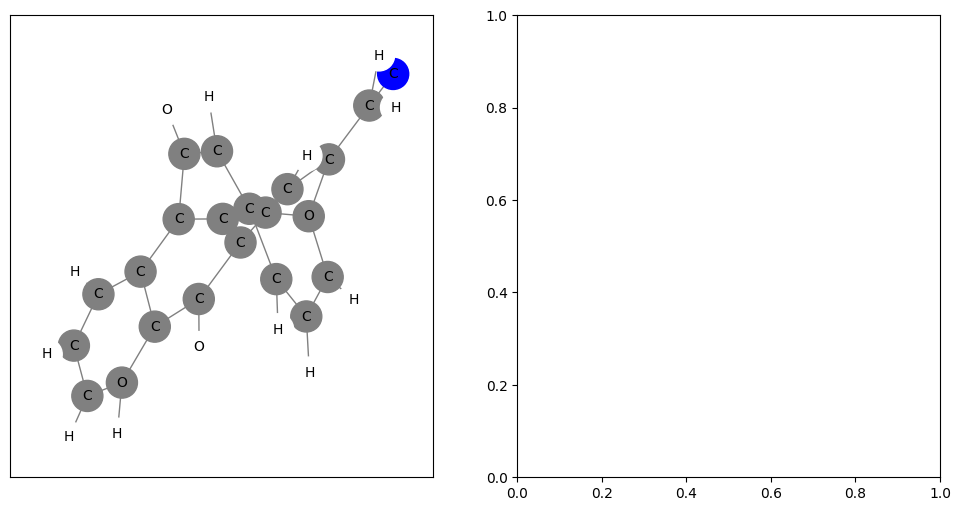

In [ ]:
j = 0
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Adjust parameters for a more molecule-like appearance
spring_layout_params = {'k': 0.3, 'iterations': 100}

# Generate a molecule-like layout for the first graph and plot it
pos0 = nx.spring_layout(graphs[0][j], **spring_layout_params)
nx.draw(graphs[0][0], pos=pos0, node_color=colors[0][0], with_labels=True,
        labels=nx.get_node_attributes(a, name="element"),
        ax=axs[0], node_size=500, font_size=10, edge_color='gray')

# Generate a molecule-like layout for the second graph and plot it
pos1 = nx.spring_layout(graphs[1][j], **spring_layout_params)
nx.draw(graphs[1][0], pos=pos1, node_color=colors[1][0], with_labels=True,
        labels=nx.get_node_attributes(a, name="element"),
        ax=axs[1], node_size=500, font_size=10, edge_color='gray')

# Display the subplots
plt.show()

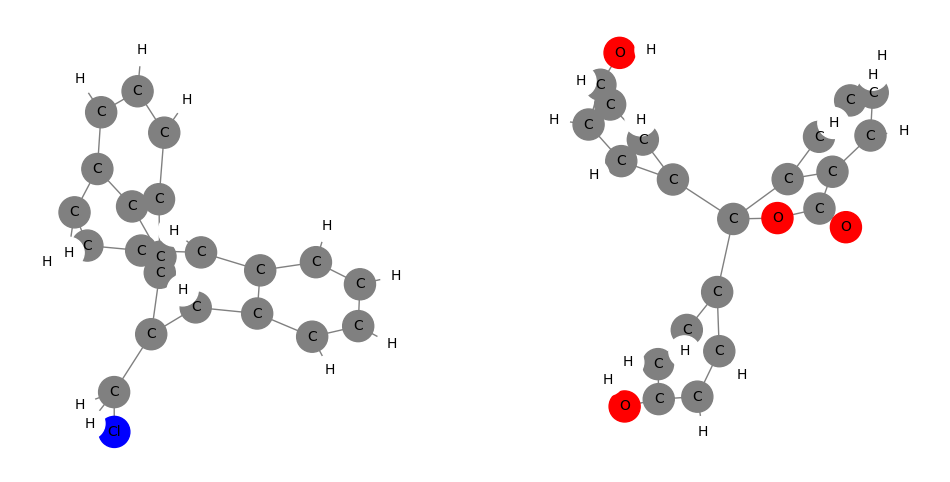

In [ ]:
j = 1
# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Adjust parameters for a more molecule-like appearance
spring_layout_params = {'k': 0.3, 'iterations': 100}

# Generate a molecule-like layout for the first graph and plot it
pos0 = nx.spring_layout(graphs[0][j], **spring_layout_params)
nx.draw(graphs[0][j], pos=pos0, node_color=colors[0][j], with_labels=True,
        labels=nx.get_node_attributes(graphs[0][j], name="element"),
        ax=axs[0], node_size=500, font_size=10, edge_color='gray')

# Generate a molecule-like layout for the second graph and plot it
pos1 = nx.spring_layout(graphs[1][j], **spring_layout_params)
nx.draw(graphs[1][j], pos=pos1, node_color=colors[1][j], with_labels=True,
        labels=nx.get_node_attributes(graphs[1][j], name="element"),
        ax=axs[1], node_size=500, font_size=10, edge_color='gray')

# Display the subplots
plt.show()

# 5.1: NCI1



In [ ]:
dataset_name = "nci1"
for i in ['benchmark']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/')[1:]:
    print(j)
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "select", threshold_theta = 0.1, cov_k = 100, radius = 0.02)
    with open(f'./results/{dataset_name}/benchmark_result/{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

results_gcfe_rand_0.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([35728, 64])
clusterize
select 23331 (35728,) 4921
summarize


100%|██████████| 100/100 [00:00<00:00, 1855.67it/s]


13 279 93 6.84854931384325
results_gcfe_rand_1.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([35379, 64])
clusterize
select 22838 (35379,) 4926
summarize


100%|██████████| 100/100 [00:00<00:00, 1498.97it/s]


12 276 95 7.211378201842308
results_gcfe_rand_2.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([34872, 64])
clusterize
select 23297 (34872,) 4575
summarize


100%|██████████| 100/100 [00:00<00:00, 2021.21it/s]


18 279 90 7.077195448800921
results_gcfe_rand_3.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([36371, 64])
clusterize
select 23610 (36371,) 4971
summarize


100%|██████████| 100/100 [00:00<00:00, 1863.96it/s]


15 272 78 7.177051430568099
results_gcfe_rand_4.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([36727, 64])
clusterize
select 23308 (36727,) 5296
summarize


100%|██████████| 100/100 [00:00<00:00, 1378.65it/s]


11 271 82 7.1380254458636045
results_cre_min.pt
select
1971 1785 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([27395, 64])
clusterize
select 18909 (27395,) 2784
summarize


100%|██████████| 100/100 [00:00<00:00, 3275.44it/s]


400 659 494 5.603231651708484
results_cre_rand_0.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([23417, 64])
clusterize
select 15781 (23417,) 2981
summarize


100%|██████████| 100/100 [00:00<00:00, 3218.12it/s]


100 361 188 6.6289944257587194
results_cre_rand_1.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([23144, 64])
clusterize
select 15426 (23144,) 3008
summarize


100%|██████████| 100/100 [00:00<00:00, 3110.39it/s]


108 358 199 6.212504779919982
results_cre_rand_2.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([23609, 64])
clusterize
select 15294 (23609,) 3147
summarize


100%|██████████| 100/100 [00:00<00:00, 2889.36it/s]


124 389 227 6.168022207915783
results_cre_rand_3.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([23667, 64])
clusterize
select 15603 (23667,) 3090
summarize


100%|██████████| 100/100 [00:00<00:00, 2933.90it/s]


120 381 212 6.354253761470318
results_cre_rand_4.pt
select
1971 1971 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([24309, 64])
clusterize
select 15172 (24309,) 3547
summarize


100%|██████████| 100/100 [00:00<00:00, 2640.35it/s]

109 371 207 6.441909711807966


In [ ]:
dataset_name = "nci1"
run_path = f'./results/{dataset_name}/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.1, cov_k = 100, radius = 0.02, select = data_length[dataset_name])
with open(f'./results/{dataset_name}/cr_select/results_gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

1971 20109 40078


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 1971/1971 [00:04<00:00, 442.38it/s]


selection:  1971 1971 40078
flatres
torch.Size([25369, 64])
clusterize
gcfe 19802 (25369,) 2435
summarize


100%|██████████| 100/100 [00:00<00:00, 3764.98it/s]


11 290 94 7.121484262868762


In [ ]:
os.listdir(f'./results/nci1/finalcre_test/')

1971 18604 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([230884, 64])
clusterize
cre 111496 (230884,) 37530
summarize


100%|██████████| 100/100 [00:00<00:00, 213.42it/s]


465 885 814 4.515212198719382


In [ ]:
dataset_name = "nci1"
for i in ['finalcre_test']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/'):
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "cre", threshold_theta = 0.1, cov_k = 100, radius = 0.02)
    with open(f'./results/{dataset_name}/cr_final/results_{i}_{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([229087, 64])
clusterize
cre 131143 (229087,) 32874
summarize


100%|██████████| 100/100 [00:00<00:00, 247.33it/s]


799 730 5.11655125208199


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([234479, 64])
clusterize
cre 125071 (234479,) 35879
summarize


100%|██████████| 100/100 [00:00<00:00, 238.14it/s]


878 794 5.071031948551536


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([235464, 64])
clusterize
cre 120028 (235464,) 37552
summarize


100%|██████████| 100/100 [00:00<00:00, 225.41it/s]


880 803 4.695732150226831


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([231661, 64])
clusterize
cre 114371 (231661,) 37959
summarize


100%|██████████| 100/100 [00:00<00:00, 218.90it/s]


845 769 4.951920079067349


In [ ]:
dataset_name = "nci1"
run_path = f'./results/nci1/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.1, cov_k = 100, radius = 0.02)
with open(f'./results/nci1/cr_final/gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

20109 40078


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([368052, 64])
clusterize
gcfe 183118 (368052,) 61302
summarize


100%|██████████| 100/100 [00:00<00:00, 144.48it/s]


421 286 5.7491179052740335


#5.2 Proteins


In [ ]:
dataset_name = "proteins"
for i in ['benchmark']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/')[1:]:
    print(j)
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "select", threshold_theta = 0.15, cov_k = 100, radius = 0.02)
    with open(f'./results/{dataset_name}/benchmark_result/{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

results_gcfe_min.pt
select
366 207 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1321, 64])
clusterize
select 1047 (1321,) 97
summarize


100%|██████████| 98/98 [00:00<00:00, 72024.14it/s]

15 81 33 11.327392694540322
results_gcfe_rand_0.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1439, 64])
clusterize
select 1082 (1439,) 149
summarize


100%|██████████| 100/100 [00:00<00:00, 47543.69it/s]

2 91 39 9.962862672284245
results_gcfe_rand_1.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1420, 64])
clusterize
select 973 (1420,) 194
summarize


100%|██████████| 100/100 [00:00<00:00, 47603.04it/s]

2 101 33 10.919921655207872
results_gcfe_rand_2.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1410, 64])
clusterize
select 928 (1410,) 195
summarize


100%|██████████| 100/100 [00:00<00:00, 39184.45it/s]

4 109 37 10.535325445234776
results_gcfe_rand_3.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1283, 64])
clusterize
select 992 (1283,) 127
summarize


100%|██████████| 100/100 [00:00<00:00, 57868.43it/s]

2 71 46 9.876269800588489
results_gcfe_rand_4.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1382, 64])
clusterize
select 995 (1382,) 172
summarize


100%|██████████| 100/100 [00:00<00:00, 52167.96it/s]

2 94 39 10.678714535199106
results_cre_min.pt


select
366 289 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1958, 64])
clusterize
select 1368 (1958,) 170
summarize


100%|██████████| 100/100 [00:00<00:00, 48770.98it/s]

40 145 67 12.040279808454216
results_cre_rand_0.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1785, 64])
clusterize
select 1173 (1785,) 230
summarize


100%|██████████| 100/100 [00:00<00:00, 34058.50it/s]

13 126 45 11.586080331355333
results_cre_rand_1.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1832, 64])
clusterize
select 1156 (1832,) 233
summarize


100%|██████████| 100/100 [00:00<00:00, 30112.03it/s]

15 133 53 11.683936486020684
results_cre_rand_2.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1792, 64])
clusterize
select 1259 (1792,) 214
summarize


100%|██████████| 100/100 [00:00<00:00, 36970.51it/s]

19 133 46 11.520868028048426
results_cre_rand_3.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1791, 64])
clusterize
select 1189 (1791,) 196
summarize


100%|██████████| 100/100 [00:00<00:00, 37735.53it/s]

14 130 39 12.056731943972409
results_cre_rand_4.pt


select
366 366 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1785, 64])
clusterize
select 1218 (1785,) 187
summarize


100%|██████████| 100/100 [00:00<00:00, 42332.50it/s]

15 129 41 11.803695726208389


In [ ]:
dataset_name = "proteins"
run_path = f'./results/{dataset_name}/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.15, cov_k = 100, radius = 0.02, select = data_length[dataset_name])
with open(f'./results/{dataset_name}/cr_select/results_gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

366 2685 13258


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 366/366 [00:00<00:00, 3507.61it/s]


selection:  366 366 13258
flatres
torch.Size([1859, 64])
clusterize
gcfe 1402 (1859,) 179
summarize


100%|██████████| 100/100 [00:00<00:00, 56481.34it/s]

4 109 32 11.132119367830455


In [ ]:
dataset_name = "proteins"
for i in ['finalcre_test']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/'):
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "cre", threshold_theta = 0.15, cov_k = 100, radius = 0.02)
    with open(f'./results/{dataset_name}/cr_final/results_{i}_{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

6373 50000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([27391, 64])
clusterize
cre 5585 (27391,) 5988
summarize


100%|██████████| 100/100 [00:00<00:00, 1366.20it/s]


41 168 106 11.435616658069193
6820 50000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([30741, 64])
clusterize
cre 5239 (30741,) 6176
summarize


100%|██████████| 100/100 [00:00<00:00, 1504.14it/s]


41 168 113 11.511161330156028
6524 50000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([30255, 64])
clusterize
cre 4704 (30255,) 5603
summarize


100%|██████████| 100/100 [00:00<00:00, 1618.69it/s]


41 169 110 11.47374982200563
6881 50000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([32567, 64])
clusterize
cre 4304 (32567,) 5686
summarize


100%|██████████| 100/100 [00:00<00:00, 1623.24it/s]


43 170 113 11.972205913625658


In [ ]:
dataset_name = "proteins"
run_path = f'./results/proteins/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.15, cov_k = 100, radius = 0.02)
with open(f'./results/proteins/cr_final/gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

366 2685 13258


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([10275, 64])
clusterize
gcfe 4988 (10275,) 1572
summarize


100%|██████████| 100/100 [00:00<00:00, 5059.41it/s]

12 120 68 10.651752665638924


#5.3 Aids

In [ ]:
dataset_name = "aids"
for i in ['benchmark']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/')[1:]:
    print(j)
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "select", threshold_theta = 0.10, cov_k = 100, radius = 0.02)
    with open(f'./results/{dataset_name}/benchmark_result/{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

results_gcfe_min.pt
select
1473 484 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([3913, 64])
clusterize
select 2301 (3913,) 619
summarize


100%|██████████| 100/100 [00:00<00:00, 15071.16it/s]


21 190 116 7.307180777192116
results_gcfe_rand_0.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([11121, 64])
clusterize
select 1542 (11121,) 2620
summarize


100%|██████████| 100/100 [00:00<00:00, 3582.21it/s]


20 177 112 7.479613117873669
results_gcfe_rand_1.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([11097, 64])
clusterize
select 1631 (11097,) 2616
summarize


100%|██████████| 100/100 [00:00<00:00, 3595.29it/s]


22 188 132 7.242589700967073
results_gcfe_rand_2.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([12114, 64])
clusterize
select 1667 (12114,) 2775
summarize


100%|██████████| 100/100 [00:00<00:00, 3368.11it/s]


14 173 117 7.444529972970486
results_gcfe_rand_3.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([11200, 64])
clusterize
select 1680 (11200,) 2624
summarize


100%|██████████| 100/100 [00:00<00:00, 3345.81it/s]


15 177 116 6.953465048223734
results_gcfe_rand_4.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([11336, 64])
clusterize
select 1629 (11336,) 2714
summarize


100%|██████████| 100/100 [00:00<00:00, 3481.15it/s]


23 184 122 7.333619296550751
results_cre_rand_0.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([4167, 64])
clusterize
select 2644 (4167,) 633
summarize


100%|██████████| 100/100 [00:00<00:00, 14520.20it/s]


18 250 188 7.801052052527666
results_cre_rand_1.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([4391, 64])
clusterize
select 2841 (4391,) 647
summarize


100%|██████████| 100/100 [00:00<00:00, 13023.77it/s]


18 235 169 7.849171310663223
results_cre_rand_2.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([4205, 64])
clusterize
select 2570 (4205,) 679
summarize


100%|██████████| 100/100 [00:00<00:00, 11786.06it/s]


15 250 191 7.5410861894488335
results_cre_rand_3.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([4233, 64])
clusterize
select 2741 (4233,) 604
summarize


100%|██████████| 100/100 [00:00<00:00, 13054.57it/s]


17 270 210 7.50747312605381
results_cre_rand_4.pt
select
1473 1473 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([3971, 64])
clusterize
select 2639 (3971,) 524
summarize


100%|██████████| 100/100 [00:00<00:00, 17369.16it/s]


14 246 194 7.336372811347246
results_cre_min.pt
select
1473 1353 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([4972, 64])
clusterize
select 3721 (4972,) 478
summarize


100%|██████████| 100/100 [00:00<00:00, 15125.51it/s]

43 358 293 6.585000738501549


In [ ]:
dataset_name = "aids"
run_path = f'./results/{dataset_name}/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.1, cov_k = 100, radius = 0.02, select = data_length[dataset_name])
with open(f'./results/{dataset_name}/cr_select/results_gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

1473 1616 14113


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 1473/1473 [00:00<00:00, 9906.14it/s]


selection:  1473 1473 14113
flatres
torch.Size([10925, 64])
clusterize
gcfe 3085 (10925,) 2451
summarize


100%|██████████| 100/100 [00:00<00:00, 3648.05it/s]


26 209 147 7.063753116875887


In [ ]:
dataset_name = "aids"
for i in ['finalcre_test']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/'):
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "cre", threshold_theta = 0.10, cov_k = 100, radius = 0.02)
    with open(f'./results/{dataset_name}/cr_final/results_{i}_{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

1473 15483 43368


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([42096, 64])
clusterize
cre 9471 (42096,) 10691
summarize


100%|██████████| 100/100 [00:00<00:00, 807.79it/s]


50 483 495 6.707869306206703
1473 20096 69225


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([57772, 64])
clusterize
cre 8403 (57772,) 13830
summarize


100%|██████████| 100/100 [00:00<00:00, 614.70it/s]


54 495 523 6.616037600673735
1473 25277 98901


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([73220, 64])
clusterize
cre 7724 (73220,) 15856
summarize


100%|██████████| 100/100 [00:00<00:00, 524.97it/s]


54 512 520 6.712767137214541
1473 26563 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([75607, 64])
clusterize
cre 7282 (75607,) 14930
summarize


100%|██████████| 100/100 [00:00<00:00, 594.07it/s]


54 511 519 6.7363856211304665
1473 27734 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([83016, 64])
clusterize
cre 6896 (83016,) 15449
summarize


100%|██████████| 100/100 [00:00<00:00, 556.18it/s]


56 519 540 6.659257926046848


In [ ]:
dataset_name = "aids"
run_path = f'./results/aids/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.10, cov_k = 100, radius = 0.02)
with open(f'./results/aids/cr_final/gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

1473 1616 14113


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([12344, 64])
clusterize
gcfe 3089 (12344,) 2713
summarize


100%|██████████| 100/100 [00:00<00:00, 3578.82it/s]


27 209 155 6.967077497392893


#5.4 Mutagenicity

In [ ]:
dataset_name = "mutagenicity"
for i in ['benchmark']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/')[:1]:
    print(j)
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "select", threshold_theta = 0.10, cov_k = 100, radius = 0.02, cluster_size = 3)
    with open(f'./results/{dataset_name}/benchmark_result/{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

results_gcfe_min.pt
select
2438 2013 0


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([74331, 64])
clusterize
select 65165 (74331,) 1969
summarize


100%|██████████| 100/100 [00:00<00:00, 4259.30it/s]


172 443 219 7.193625586107373


In [ ]:
dataset_name = "mutagenicity"
run_path = f'./results/{dataset_name}/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.1, cov_k = 100, radius = 0.02, select = data_length[dataset_name])
with open(f'./results/{dataset_name}/cr_select/results_gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

2438 25670 42377


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 2438/2438 [00:07<00:00, 332.97it/s]


selection:  2438 2438 42377
flatres
torch.Size([65803, 64])
clusterize
gcfe 38051 (65803,) 10034
summarize


100%|██████████| 100/100 [00:00<00:00, 781.19it/s]


15 289 60 7.803455926477909


In [ ]:
dataset_name = "mutagenicity"
for i in ['finalcre_test']:
  for j in os.listdir(f'./results/{dataset_name}/{i}/')[1:]:
    run_path = f'./results/{dataset_name}/{i}/{j}'
    rez = CR_from_can(dataset_name, run_path, method = "cre", threshold_theta = 0.1, cov_k = 100, radius = 0.02, cluster_size = 3)
    with open(f'./results/{dataset_name}/cr_final/results_{i}_{j[:-3]}.pkl', 'wb') as f:
      pickle.dump(rez, f)

2438 31019 124797


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1115621, 64])
clusterize
cre 626736 (1115621,) 80548
summarize


100%|██████████| 100/100 [00:01<00:00, 88.86it/s]


899 1283 1237 5.60546287894249
2438 22688 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([815609, 64])
clusterize
cre 454680 (815609,) 60707
summarize


100%|██████████| 100/100 [00:00<00:00, 125.45it/s]


933 1279 1166 5.666990900412202
2438 22357 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([784008, 64])
clusterize
cre 443884 (784008,) 56922
summarize


100%|██████████| 100/100 [00:00<00:00, 128.38it/s]


928 1269 1157 5.730592615902424
2438 25287 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([928923, 64])
clusterize
cre 539476 (928923,) 66499
summarize


100%|██████████| 100/100 [00:00<00:00, 117.78it/s]


906 1268 1186 5.807662659324706
2438 24544 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([916696, 64])
clusterize
cre 526824 (916696,) 64436
summarize


100%|██████████| 100/100 [00:00<00:00, 126.21it/s]


889 1264 1172 5.62884592730552
2438 24033 100000


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([862068, 64])
clusterize
cre 493760 (862068,) 61683
summarize


100%|██████████| 100/100 [00:00<00:00, 122.11it/s]


909 1268 1168 5.681745615787804


In [ ]:
dataset_name = "mutagenicity"
run_path = f'./results/mutagenicity/runs/counterfactuals.pt'
rez = CR_from_can(dataset_name, run_path, method = "gcfe", threshold_theta = 0.1, cov_k = 100, radius = 0.02, cluster_size = 3)
with open(f'./results/mutagenicity/cr_final/gcfe.pkl', 'wb') as f:
  pickle.dump(rez, f)

2438 25670 42377


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


flatres
torch.Size([1075432, 64])
clusterize
gcfe 707919 (1075432,) 74591
summarize


100%|██████████| 100/100 [00:01<00:00, 84.16it/s]


172 503 337 6.911664294078946


#6 Sum up metrics

In [ ]:
data_length = {'mutagenicity': 2438, 'proteins': 366, 'aids': 1473, 'nci1': 1971}

In [ ]:
dataset_name = "mutagenicity"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/cr_select/'):
  with open(f'./results/{dataset_name}/cr_select/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

results_cre.pkl 23.99507793273175 6.861527459695935
results_gcfe.pkl 11.853978671041837 7.803455926477909
results_nat.pkl 10.377358490566039 8.342451120726764
results_nat_2.pkl 10.377358490566039 8.34245104342699


In [ ]:
dataset_name = "mutagenicity"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/benchmark_result/'):
  with open(f'./results/{dataset_name}/benchmark_result/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

results_gcfe_min.pkl 18.170631665299425 7.193625586107373
results_gcfe_rand_0.pkl 11.936013125512716 7.999020079150796
results_gcfe_rand_1.pkl 11.853978671041837 7.802672099787742
results_gcfe_rand_2.pkl 11.689909762100081 7.769652400165796
results_gcfe_rand_3.pkl 12.018047579983593 8.149914263747633
results_gcfe_rand_4.pkl 11.936013125512716 8.126028997823596
results_cre_min.pkl 46.71862182116489 6.563557806424797
results_cre_rand_0.pkl 22.27235438884331 6.86675937846303
results_cre_rand_1.pkl 23.379819524200162 6.989830045029521
results_cre_rand_2.pkl 23.256767842493847 7.121729829348624
results_cre_rand_3.pkl 23.666940114848238 7.044563008472323
results_cre_rand_4.pkl 22.47744052502051 7.368355613201857


In [ ]:
dataset_name = "aids"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/cr_select/'):
  with open(f'./results/{dataset_name}/cr_select/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

results_cre.pkl 20.095044127630686 7.432935442775488
results_gcfe.pkl 14.188730482009504 7.063753116875887
results_nat.pkl 0.0678886625933469 0.3478224575519562
results_nat_2.pkl 0.40733197556008144 0.9737056642770767


In [ ]:
dataset_name = "aids"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/benchmark_result/'):
  with open(f'./results/{dataset_name}/benchmark_result/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

results_gcfe_min.pkl 12.898845892735913 7.307180777192116
results_gcfe_rand_0.pkl 12.016293279022404 7.479613117873669
results_gcfe_rand_1.pkl 12.763068567549219 7.242589700967073
results_gcfe_rand_2.pkl 11.744738628649015 7.444529972970486
results_gcfe_rand_3.pkl 12.016293279022404 6.953465048223734
results_gcfe_rand_4.pkl 12.491513917175832 7.333619296550751
results_cre_rand_0.pkl 16.97216564833673 7.801052052527666
results_cre_rand_1.pkl 15.953835709436524 7.849171310663223
results_cre_rand_2.pkl 16.97216564833673 7.5410861894488335
results_cre_rand_3.pkl 18.329938900203665 7.50747312605381
results_cre_rand_4.pkl 16.700610997963338 7.336372811347246
results_cre_min.pkl 24.304141208418194 6.585000738501549


In [ ]:
dataset_name = "nci1"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/cr_select/'):
  with open(f'./results/{dataset_name}/cr_select/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

results_cre.pkl 22.628107559614406 6.541341399773955
results_gcfe.pkl 14.713343480466767 7.121484262868762
results_nat.pkl 8.52359208523592 8.875232718884945
results_nat_2.pkl 8.52359208523592 9.019060969352722


In [ ]:
dataset_name = "nci1"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/benchmark_result/'):
  if i[-1] != "s":
    with open(f'./results/{dataset_name}/benchmark_result/{i}', 'rb') as handle:
      cov, size, cost = pickle.load(handle)
    print(i, cov[-1]/l*100, cost[-1])

results_gcfe_min.pkl 19.025875190258752 5.892179038375616
results_gcfe_rand_0.pkl 14.15525114155251 6.84854931384325
results_gcfe_rand_1.pkl 14.00304414003044 7.211378201842308
results_gcfe_rand_2.pkl 14.15525114155251 7.077195448800921
results_gcfe_rand_3.pkl 13.800101471334347 7.177051430568099
results_gcfe_rand_4.pkl 13.749365804160323 7.1380254458636045
results_cre_min.pkl 33.43480466768138 5.603231651708484
results_cre_rand_0.pkl 18.315575849822423 6.6289944257587194
results_cre_rand_1.pkl 18.163368848300355 6.212504779919982
results_cre_rand_2.pkl 19.736174530695077 6.168022207915783
results_cre_rand_3.pkl 19.330289193302892 6.354253761470318
results_cre_rand_4.pkl 18.822932521562656 6.441909711807966


In [ ]:
dataset_name = "proteins"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/cr_select/'):
  with open(f'./results/{dataset_name}/cr_select/{i}', 'rb') as handle:
    cov, size, cost = pickle.load(handle)
  print(i, cov[-1]/l*100, cost[-1])

results_cre.pkl 34.42622950819672 11.935233830474317
results_gcfe.pkl 29.78142076502732 11.132119367830455
results_nat.pkl 3.551912568306011 2.614148572087288
results_nat_2.pkl 28.96174863387978 12.952793441712856


In [ ]:
dataset_name = "proteins"
l = data_length[dataset_name]
for i in os.listdir(f'./results/{dataset_name}/benchmark_result/'):
  if i[-1] != "s":
    with open(f'./results/{dataset_name}/benchmark_result/{i}', 'rb') as handle:
      cov, size, cost = pickle.load(handle)
    print(i, cov[-1]/l*100, cost[-1])

results_gcfe_min.pkl 22.131147540983605 11.327392694540322
results_gcfe_rand_0.pkl 24.863387978142075 9.962862672284245
results_gcfe_rand_1.pkl 27.595628415300546 10.919921655207872
results_gcfe_rand_2.pkl 29.78142076502732 10.535325445234776
results_gcfe_rand_3.pkl 19.398907103825135 9.876269800588489
results_gcfe_rand_4.pkl 25.683060109289617 10.678714535199106
results_cre_min.pkl 39.61748633879781 12.040279808454216
results_cre_rand_0.pkl 34.42622950819672 11.586080331355333
results_cre_rand_1.pkl 36.33879781420765 11.683936486020684
results_cre_rand_2.pkl 36.33879781420765 11.520868028048426
results_cre_rand_3.pkl 35.51912568306011 12.056731943972409
results_cre_rand_4.pkl 35.24590163934426 11.803695726208389


# Final

In [ ]:
rez = dict()
for dataset_name in ["aids", "nci1", "mutagenicity", "proteins"]:
  rez[dataset_name] = []

  with open(f'/content/drive/MyDrive/COMRECGC/results/{dataset_name}/cr_select/results_nat_2.pkl', 'rb') as handle:
    rez[dataset_name].append(pickle.load(handle))

  with open(f'/content/drive/MyDrive/COMRECGC/results/{dataset_name}/benchmark_result/results_gcfe_min.pkl', 'rb') as handle:
    rez[dataset_name].append(pickle.load(handle))

  with open(f'/content/drive/MyDrive/COMRECGC/results/{dataset_name}/cr_select/results_gcfe.pkl', 'rb') as handle:
    rez[dataset_name].append(pickle.load(handle))

  with open(f'/content/drive/MyDrive/COMRECGC/results/{dataset_name}/benchmark_result/results_cre_min.pkl', 'rb') as handle:
    rez[dataset_name].append(pickle.load(handle))


NameError: name 'rez' is not defined

<ipython-input-81-b4880cc03798>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


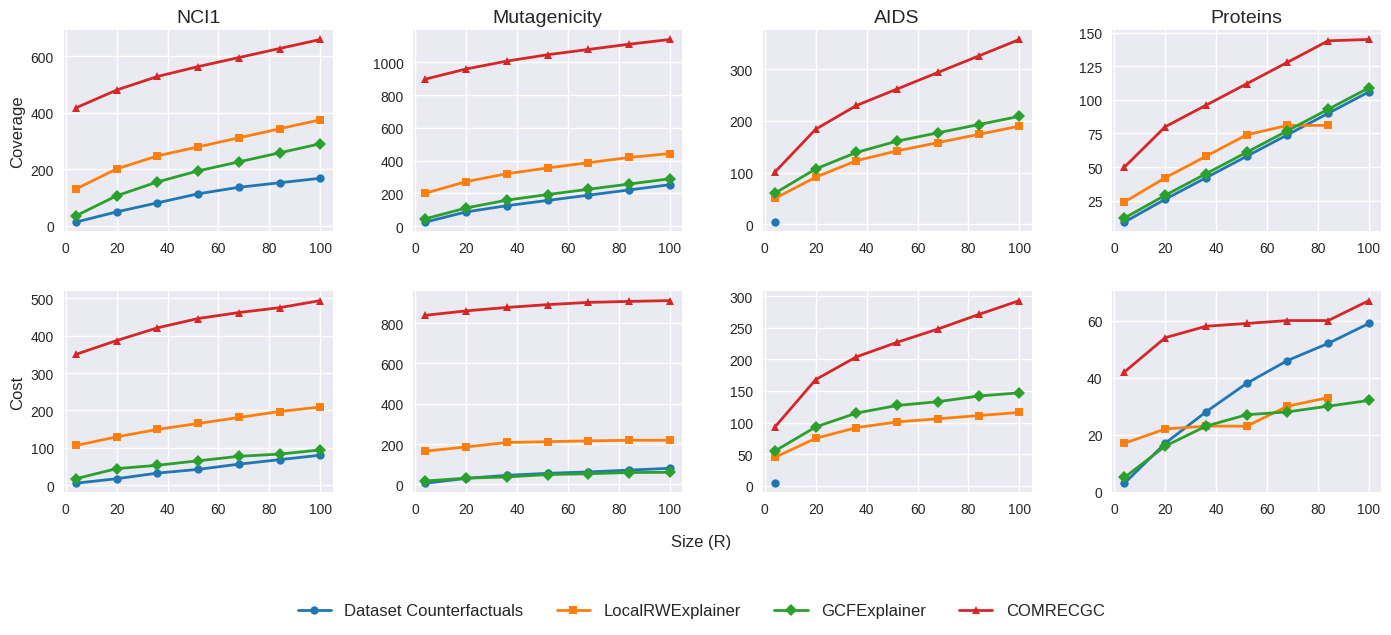

In [ ]:
X = np.arange(4,101,16)

# Use the seaborn style
plt.style.use('seaborn')

# Define a color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', 'D', '^']

# Create the subplots
figure, axis = plt.subplots(2, 4, figsize=(17, 6))

# Set the y-axis labels
axis[0, 0].set_ylabel("Coverage", fontsize=12)
axis[1, 0].set_ylabel("Cost", fontsize=12)

# Define labels for legend
labels = ['Dataset Counterfactuals', 'LocalRWExplainer', 'GCFExplainer', 'COMRECGC']

# Function to plot data
def plot_data(ax, data, title):
    for i, (color, marker) in enumerate(zip(colors, markers)):
        if title == "Proteins" and i == 1:
            ax.plot(X[:-1], [data[i][0][j-1] for j in X[:-1]], marker=marker, color=color, label=labels[i], linewidth=2, markersize=6)
        elif title == "AIDS" and i == 0:
            ax.plot(X[:1], [data[i][0][j-1] for j in X[:1]], marker=marker, color=color, label=labels[i], linewidth=2, markersize=6)
        else:
            ax.plot(X, [data[i][0][j-1] for j in X], marker=marker, color=color, label=labels[i], linewidth=2, markersize=6)
    ax.set_title(title, fontsize=14)
    ax.grid(True)

# Plot data
plot_data(axis[0, 0], rez["nci1"], "NCI1")
plot_data(axis[0, 1], rez["mutagenicity"], "Mutagenicity")
plot_data(axis[0, 2], rez["aids"], "AIDS")
plot_data(axis[0, 3], rez["proteins"], "Proteins")

# Adjust the second row
for i, data_key in enumerate(["nci1", "mutagenicity", "aids", "proteins"]):
    for j, (color, marker) in enumerate(zip(colors, markers)):
        if data_key == "proteins" and j == 1:
            axis[1, i].plot(X[:-1], [rez[data_key][j][1][k-1] for k in X[:-1]], marker=marker, color=color, linewidth=2, markersize=6)
        elif data_key == "aids" and j == 0:
            axis[1, i].plot(X[:1], [rez[data_key][j][1][k-1] for k in X[:1]], marker=marker, color=color, linewidth=2, markersize=6)
        else:
            axis[1, i].plot(X, [rez[data_key][j][1][k-1] for k in X], marker=marker, color=color, linewidth=2, markersize=6)
    axis[1, i].grid(True)

# Add common legend
figure.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

# Add common x-axis label
figure.text(0.5, 0.02, 'Size (R)', ha='center', fontsize=12)

# Adjust subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Save the figure as a PDF
plt.savefig('plot.pdf', format='pdf')

plt.show()
